## 1. feladat

In [51]:
# 1. CELLA: KÖNYVTÁRAK ÉS ADATELŐKÉSZÍTÉS (JAVÍTOTT DÁTUMKEZELÉSSEL)
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t as tdist
import yfinance as yf

In [52]:
# ---------------------------------------------------------
# 1. ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE
# ---------------------------------------------------------
print("Adatok betöltése és előkészítése...")

# Fájlok beolvasása
s = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
m = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
r = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

# Dátumok technikai igazítása (hogy biztosan egyezzenek)
s.index = s.index.to_period('M').to_timestamp()
m.index = m.index.to_period('M').to_timestamp()
r.index = r.index.to_period('M').to_timestamp()

# Kockázatmentes hozam előkészítése
# Keressük meg a megfelelő oszlopot (bármi is a neve) és csináljuk meg a LAG-ot
rf_col = r.columns[0]
r = r.rename(columns={rf_col: 'Risk_Free_Rate'})
rf_lag = r['Risk_Free_Rate'].shift(1) # Elcsúsztatás

# Összefésülés a közös dátumokra
df = s.join(m, how='inner').join(rf_lag, how='inner')

# Piaci oszlop azonosítása és átnevezése
market_col = [c for c in df.columns if c not in s.columns and c != 'Risk_Free_Rate'][0]
df = df.rename(columns={market_col: 'SP100_rp'})

# --- TÖBBLETHOZAM SZÁMÍTÁS ---
# Kivonjuk a kockázatmentes hozamot (rf_lag) mindenből (Részvényekből és Piacból is)
# (Kivéve magát a Risk_Free_Rate oszlopot)
cols_to_adjust = [c for c in df.columns if c != 'Risk_Free_Rate']
RP = df[cols_to_adjust].sub(df['Risk_Free_Rate'], axis=0)

# --- A TANÁR KÉRÉSE: OSZLOPOK TÖRLÉSE ---
# 1. Először eldobjuk az első sort, mert a shift(1) miatt ott minden NaN
RP = RP.iloc[1:]

# 2. Most eldobjuk azokat az OSZLOPOKAT (részvényeket), ahol bárhol máshol hiány van
# axis=1 jelenti az oszlopot
original_count = len(RP.columns)
RP_aligned = RP.dropna(axis=1, how='any')
final_count = len(RP_aligned.columns)

print(f"Eredeti részvények száma (piaccal): {original_count}")
print(f"Megmaradt részvények száma (hiányosak törölve): {final_count}")
print(f"Elemzett időszak hossza: {len(RP_aligned)} hónap")

Adatok betöltése és előkészítése...
Eredeti részvények száma (piaccal): 102
Megmaradt részvények száma (hiányosak törölve): 81
Elemzett időszak hossza: 309 hónap


In [53]:
# ---------------------------------------------------------
# 2. FÜGGVÉNY (Visszaállítva a start/end szűrést!)
# ---------------------------------------------------------
def excel_first_pass(RP, start, end):
    # 1. SZŰRÉS: Kivágjuk a kért időszakot
    RP_period = RP.loc[start:end]
    
    # Itt már biztosan létezik az oszlop
    RM = RP_period['SP100_rp']
    rows = []
    
    for ticker in RP_period.columns:
        if ticker == 'SP100_rp': continue
        
        # Egyedi tisztítás
        stock_data = pd.concat([RP_period[ticker], RM], axis=1).dropna()
        
        if len(stock_data) < 12: continue 
        
        Ri = stock_data[ticker]
        Rm_clean = stock_data['SP100_rp']
        
        # Számítások
        cov = np.cov(Ri, Rm_clean)[0, 1]
        var = np.var(Rm_clean, ddof=1)
        beta = cov / var
        
        alpha = Ri.mean() - beta * Rm_clean.mean()
        
        # Idioszinkratikus variancia (Sigma^2)
        sigma2 = np.var(Ri - beta * Rm_clean, ddof=1)
        
        # Átlagos hozam (a 2. lépéshez kell)
        riskprem_mean = Ri.mean()
        
        rows.append([ticker, beta, alpha, sigma2, riskprem_mean])
        
    return pd.DataFrame(rows, columns=['Ticker', 'beta', 'alpha', 'sigma2', 'riskprem_mean'])


Regresszió futtatása (2000-01-01 -> 2025-11-01)...

Eredmények (első 5 sor):
  Ticker     beta    alpha   sigma2  riskprem_mean
0   AAPL 1.372698 0.017906 0.008271       0.023902
1   ABBV 0.680356 0.009475 0.004696       0.016425
2    ABT 0.504081 0.006942 0.002744       0.009144
3    ACN 1.122140 0.006029 0.002934       0.012169
4   ADBE 1.334880 0.008933 0.008800       0.014764


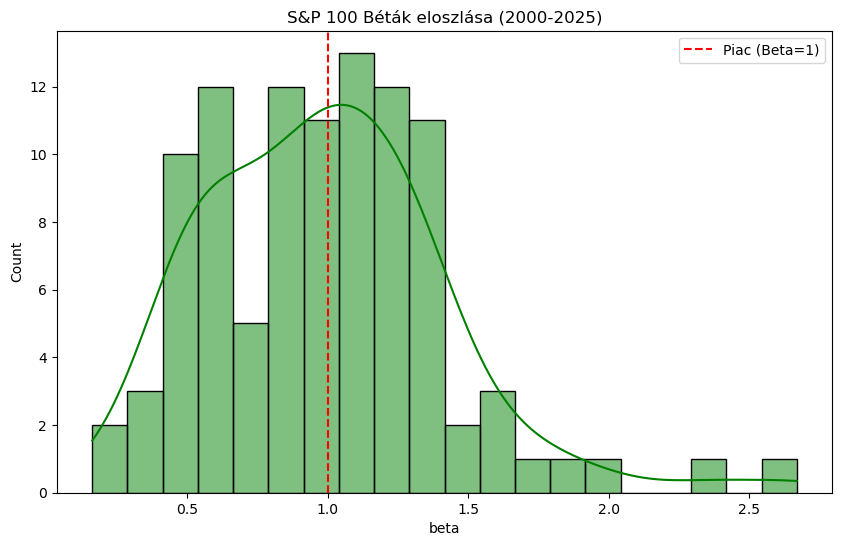

In [54]:
# ---------------------------------------------------------
# 3. FUTTATÁS (2000-2025)
# ---------------------------------------------------------
print("Regresszió futtatása (2000-01-01 -> 2025-11-01)...")

first_pass_results = excel_first_pass(RP, '2000-01-01', '2025-11-01')

print("\nEredmények (első 5 sor):")
print(first_pass_results.head())

# Ábra
plt.figure(figsize=(10,6))
sns.histplot(first_pass_results['beta'], bins=20, kde=True, color='green')
plt.title("S&P 100 Béták eloszlása (2000-2025)")
plt.axvline(x=1, color='red', linestyle='--', label='Piac (Beta=1)')
plt.legend()
plt.show()

In [55]:
# ---------------------------------------------------------
# 4. SECOND-PASS REGRESSZIÓ (Keresztmetszeti)
# ---------------------------------------------------------
# Teszteljük a SML egyenletet: E(Ri) = gamma0 + gamma1 * beta (+ gamma2 * sigma2)
# CAPM szerint: gamma0 = 0, gamma1 = E(Rm) - Rf, gamma2 = 0

print("\nSecond-pass regresszió futtatása...")

# Adatok előkészítése
valid_data = first_pass_results.set_index('Ticker')
y = valid_data['riskprem_mean'] # Függő változó: Átlagos többlethozam

# Modell 1: Csak Beta (Klasszikus CAPM teszt)
X1 = sm.add_constant(valid_data[['beta']]) # Konstans (gamma0) + Beta (gamma1)
model1 = sm.OLS(y, X1).fit()

# Modell 2: Beta + Sigma^2 (Ellenőrizzük, hogy a nem-szisztematikus kockázat számít-e)
X2 = sm.add_constant(valid_data[['beta', 'sigma2']])
model2 = sm.OLS(y, X2).fit()

# Eredmények kiírása
print("-" * 50)
print("MODELL 1 (Csak Beta):")
print(model1.summary())
print("-" * 50)
print("MODELL 2 (Beta + Idioszinkratikus kockázat):")
print(model2.summary())


Second-pass regresszió futtatása...
--------------------------------------------------
MODELL 1 (Csak Beta):
                            OLS Regression Results                            
Dep. Variable:          riskprem_mean   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     43.17
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           2.36e-09
Time:                        21:50:45   Log-Likelihood:                 338.21
No. Observations:                 101   AIC:                            -672.4
Df Residuals:                      99   BIC:                            -667.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

Adatok sikeresen betöltve az RP_aligned táblából.
Regressziók futtatása...


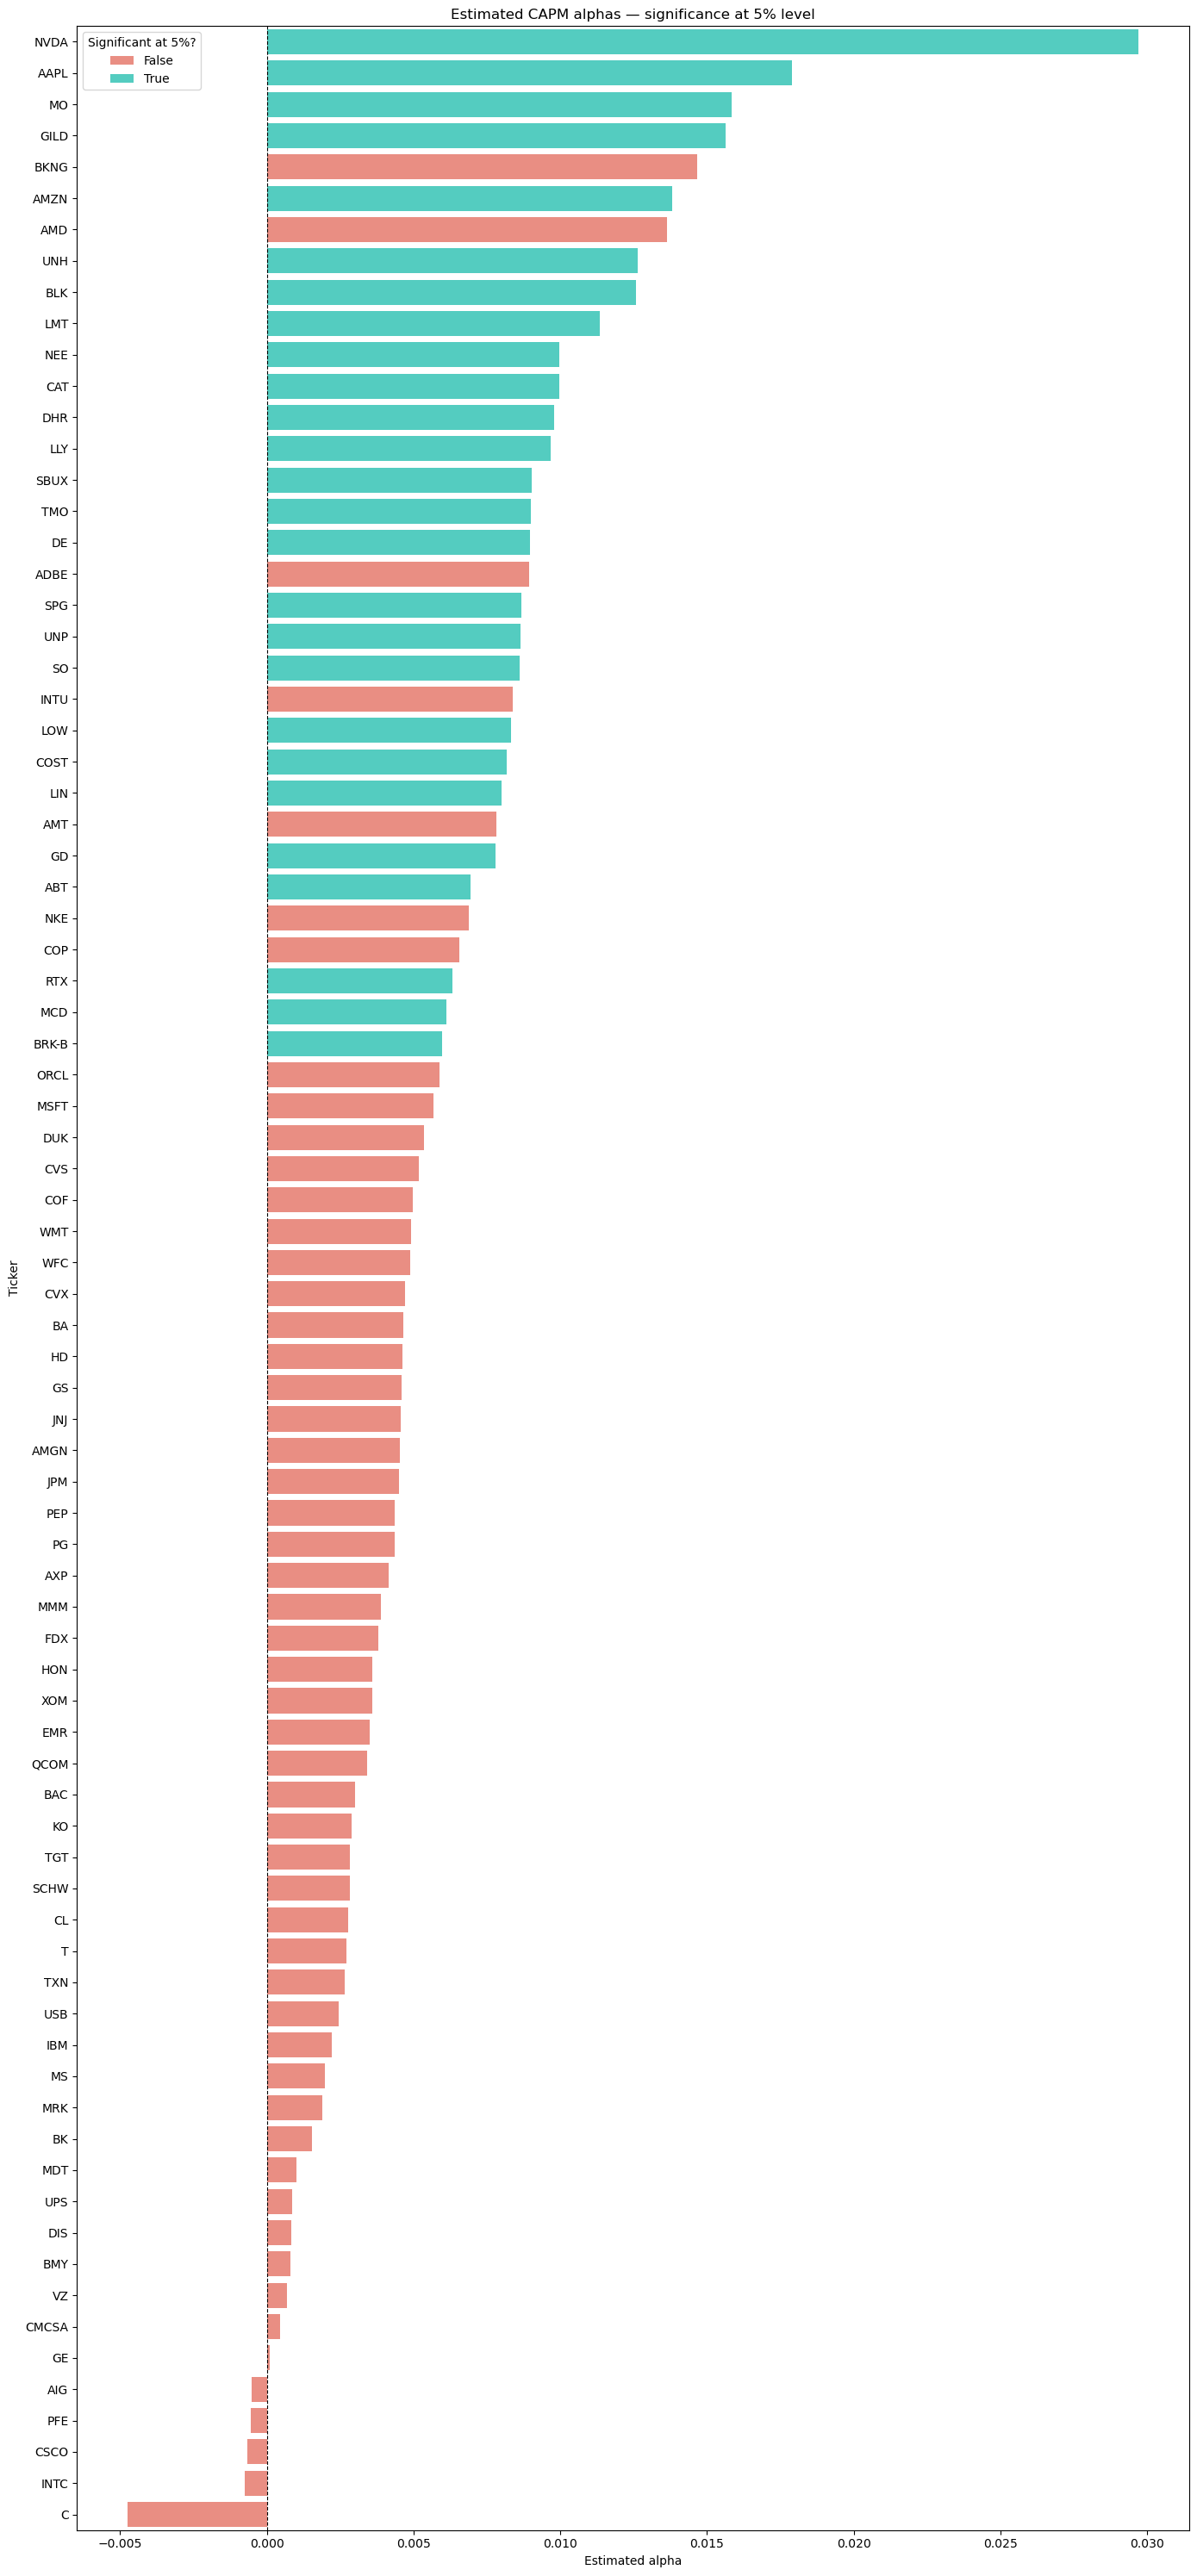

In [56]:
# 1. Adatok kinyerése az RP_aligned-ből
excess_market = RP_aligned['SP100_rp']  # Ez a piaci prémium (Rm - Rf)
excess_stocks = RP_aligned.drop(columns=['SP100_rp']) # Ezek a részvények prémiumai (Ri - Rf)

print("Adatok sikeresen betöltve az RP_aligned táblából.")

# --- 2. PARAMÉTEREK BECSLÉSE (First Pass) ---
# Szükségünk van az Alphákra és a Sigma^2-re (egyedi kockázat)
results_list = []

# Piaci hozam statisztikái a képletedhez
RM = excess_market
RM_mean = RM.mean()
RM_var = RM.var(ddof=1)
N = len(RM)

print("Regressziók futtatása...")
for stock in excess_stocks.columns:
    Y = excess_stocks[stock]
    X = sm.add_constant(RM) # Konstans hozzáadása az Alphához
    
    model = sm.OLS(Y, X).fit()
    
    # Eredmények kinyerése
    alpha = model.params.iloc[0]
    beta = model.params.iloc[1]
    sigma2 = np.var(model.resid) # Reziduális variancia
    
    results_list.append({
        'Ticker': stock,
        'beta': beta,
        'alpha': alpha,
        'sigma2': sigma2
    })

# DataFrame a plotoláshoz
plot_df = pd.DataFrame(results_list)

# --- 3. STATISZTIKAI SZÁMÍTÁS (A te logikád alapján) ---
# Alpha Standard Error számítása az általad megadott képlettel
plot_df['alpha_se'] = np.sqrt(
    plot_df['sigma2'] * (1 + (RM_mean**2)/RM_var) / N
)

# t-statisztika (H0: alpha = 0)
plot_df['tstat'] = plot_df['alpha'] / plot_df['alpha_se']

# p-érték (kétoldali)
plot_df['pval'] = 2 * (1 - tdist.cdf(np.abs(plot_df['tstat']), df=N-2))

# Szignifikancia (5%-os szint)
plot_df['significant'] = plot_df['pval'] < 0.05

# Rendezés a szép ábrához
plot_df = plot_df.sort_values('alpha', ascending=False)

# --- 4. VIZUALIZÁCIÓ ---
plt.figure(figsize=(14, 30)) # Magasabb ábra, hogy minden elférjen
sns.barplot(
    data=plot_df,
    y='Ticker',
    x='alpha',
    hue='significant',
    palette={True: 'turquoise', False: 'salmon'},
    dodge=False
)

plt.title('Estimated CAPM alphas — significance at 5% level')
plt.xlabel('Estimated alpha')
plt.ylabel('Ticker')
plt.legend(title='Significant at 5%?')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [57]:
# ---------------------------------------------------------
# HIPOTÉZIS VIZSGÁLAT - CAPM TESZTEK (TELJES VERZIÓ)
# ---------------------------------------------------------
from scipy.stats import t as tdist

# Piaci többlethozamok elkészítése
excess_market = RP_aligned['SP100_rp']  # Ez a piaci prémium (Rm - Rf)
excess_stocks = RP_aligned.drop(columns=['SP100_rp']) # Ezek a részvények prémiumai (Ri - Rf)

print('\n' + '='*70)
print('CAPM HYPOTHESIS TESTS (Havi adatok, 2000-2025)')
print('='*70)

# Piaci átlagos többlethozam
market_rp = excess_market.mean()
n = valid_data.shape[0]
alpha_level = 0.05  # 5%-os szignifikancia szint

print(f'\nMinta mérete (n): {n}')
print(f'Piaci átlagos többlethozam (E[Rm - Rf]): {market_rp:.6f}')

# --- Model 1 (Beta only) ---
print('\n' + '-'*70)
print('MODEL 1: Klasszikus CAPM (csak Beta)')
print('-'*70)

gamma0_1 = model1.params['const']
gamma1_1 = model1.params['beta']
se0_1 = model1.bse['const']
se1_1 = model1.bse['beta']
df1 = n - 2

# Gamma 0 teszt: H0: gamma0 = 0
t0_1 = gamma0_1 / se0_1
p0_1 = 2 * (1 - tdist.cdf(abs(t0_1), df1))

print(f'\nγ0 (Intercept):')
print(f'  Becsült érték: {gamma0_1:.6f}')
print(f'  t-statisztika: {t0_1:.4f}')
print(f'  p-érték: {p0_1:.6f} → {"ELVETJÜK" if p0_1 < alpha_level else "ELFOGADJUK"}')

# Gamma 1 teszt: H0: gamma1 = market_rp
t1_1 = (gamma1_1 - market_rp) / se1_1
p1_1 = 2 * (1 - tdist.cdf(abs(t1_1), df1))

print(f'\nγ1 (Slope):')
print(f'  Becsült érték: {gamma1_1:.6f}')
print(f'  Elméleti érték: {market_rp:.6f}')
print(f'  t-statisztika: {t1_1:.4f}')
print(f'  p-érték: {p1_1:.6f} → {"ELVETJÜK" if p1_1 < alpha_level else "ELFOGADJUK"}')

# --- Model 2 (Beta + Sigma2) ---
print('\n' + '-'*70)
print('MODEL 2: Kiterjesztett CAPM (Beta + Idioszinkratikus Kockázat)')
print('-'*70)

gamma0_2 = model2.params['const']
gamma1_2 = model2.params['beta']
gamma2_2 = model2.params['sigma2']
se0_2 = model2.bse['const']
se1_2 = model2.bse['beta']
se2_2 = model2.bse['sigma2']
df2 = n - 3

t0_2 = gamma0_2 / se0_2
p0_2 = 2 * (1 - tdist.cdf(abs(t0_2), df2))

print(f'\nγ0 (Intercept): p={p0_2:.6f} → {"ELVETJÜK" if p0_2 < alpha_level else "ELFOGADJUK"}')

t1_2 = (gamma1_2 - market_rp) / se1_2
p1_2 = 2 * (1 - tdist.cdf(abs(t1_2), df2))

print(f'γ1 (Slope): p={p1_2:.6f} → {"ELVETJÜK" if p1_2 < alpha_level else "ELFOGADJUK"}')

t2_2 = gamma2_2 / se2_2
p2_2 = 2 * (1 - tdist.cdf(abs(t2_2), df2))

print(f'γ2 (Sigma^2): p={p2_2:.6f} → {"ELVETJÜK (CAPM sérül)" if p2_2 < alpha_level else "ELFOGADJUK (CAPM OK)"}')

# --- ÖSSZEFOGLALÓ ---
print('\n' + '='*70)
if p0_1 >= alpha_level and p1_1 >= alpha_level:
    print("✓ KLASSZIKUS CAPM: Empirikusan támogatott!")
else:
    print("✗ KLASSZIKUS CAPM: Empirikusan NEM támogatott!")
print('='*70)



CAPM HYPOTHESIS TESTS (Havi adatok, 2000-2025)

Minta mérete (n): 101
Piaci átlagos többlethozam (E[Rm - Rf]): 0.004368

----------------------------------------------------------------------
MODEL 1: Klasszikus CAPM (csak Beta)
----------------------------------------------------------------------

γ0 (Intercept):
  Becsült érték: -0.000417
  t-statisztika: -0.1921
  p-érték: 0.848035 → ELFOGADJUK

γ1 (Slope):
  Becsült érték: 0.013234
  Elméleti érték: 0.004368
  t-statisztika: 4.4018
  p-érték: 0.000027 → ELVETJÜK

----------------------------------------------------------------------
MODEL 2: Kiterjesztett CAPM (Beta + Idioszinkratikus Kockázat)
----------------------------------------------------------------------

γ0 (Intercept): p=0.002503 → ELVETJÜK
γ1 (Slope): p=0.130622 → ELFOGADJUK
γ2 (Sigma^2): p=0.000000 → ELVETJÜK (CAPM sérül)

✗ KLASSZIKUS CAPM: Empirikusan NEM támogatott!


In [64]:
def analyze_capm_frequency(name, RP_data, market_col_name='SP100_rp'):
    """
    CAPM Model 1 és Model 2 elemzés az 1. feladat RP_aligned adataira.
    
    JAVÍTÁS: Most az 1. feladat Model 1 (csak Beta) p-értékét is visszaadja!
    """
    try:
        stocks_available = [c for c in RP_data.columns if c != market_col_name]
        
        if len(stocks_available) < 10:
            print(f"⚠ {name}: túl kevés részvény ({len(stocks_available)})")
            return None
        
        # FIRST PASS: Idősoros regresszió (egyedi stocks)
        betas = []
        avg_excess_ret = []
        var_residuals = []
        
        X = sm.add_constant(RP_data[market_col_name])
        
        for stock in stocks_available:
            y = RP_data[stock]
            model = sm.OLS(y, X).fit()
            
            betas.append(model.params[market_col_name])
            avg_excess_ret.append(y.mean())
            var_residuals.append(model.mse_resid)
        
        # SECOND PASS: Keresztmetszeti regresszió
        sec_pass_data = pd.DataFrame({
            'MeanExcessRet': avg_excess_ret,
            'beta': betas,
            'sigma2': var_residuals
        }, index=stocks_available)
        
        market_rp_mean = RP_data[market_col_name].mean()
        n_obs = len(sec_pass_data)
        
        # ===== MODEL 1: Csak Beta (1. FELADAT) =====
        X1 = sm.add_constant(sec_pass_data[['beta']])
        model1 = sm.OLS(sec_pass_data['MeanExcessRet'], X1).fit()
        
        g1_m1 = model1.params['beta']
        seg1_m1 = model1.bse['beta']
        df1 = n_obs - 2
        t_g1_m1 = (g1_m1 - market_rp_mean) / seg1_m1
        p_gamma1_M1 = 2 * (1 - tdist.cdf(abs(t_g1_m1), df1))
        
        # ===== MODEL 2: Beta + Sigma2 (2.B FELADAT) =====
        X2 = sm.add_constant(sec_pass_data[['beta', 'sigma2']])
        model2 = sm.OLS(sec_pass_data['MeanExcessRet'], X2).fit()
        
        df2 = n_obs - 3
        
        p_gamma0_M2 = model2.pvalues['const']
        
        g1_m2 = model2.params['beta']
        seg1_m2 = model2.bse['beta']
        t_g1_m2 = (g1_m2 - market_rp_mean) / seg1_m2
        p_gamma1_M2 = 2 * (1 - tdist.cdf(abs(t_g1_m2), df2))
        
        p_gamma2_M2 = model2.pvalues['sigma2']
        
        return {
            'Frekvencia': name,
            'N_stocks': len(betas),
            'N_periods': len(RP_data),
            'Piaci_RP': market_rp_mean,
            # JAVÍTÁS: Hozzáadva az 1. feladat Model 1 p-értéke
            'p_gamma1_M1': p_gamma1_M1,
            # 2.B feladat Model 2 p-értékei
            'p_gamma0_M2': p_gamma0_M2,
            'p_gamma1_M2': p_gamma1_M2,
            'p_gamma2_M2': p_gamma2_M2,
        }
        
    except Exception as e:
        print(f"✗ HIBA {name}: {str(e)}")
        return None


In [74]:
from scipy.stats import t as tdist

# CAPM hipotézis vizsgálat - γ₁ = átlagos piaci risk premium?
print('=== CAPM HYPOTHESIS TESTS ===')
market_rp = RP_aligned['SP100_rp'].mean()

# Próbáld meg így - az X2 mátrix mérete alapján
n = X2.shape[0]  # Az X2 a second pass regresszióban használt mátrix

# Model 1, t-stat, p érték
gamma1_1 = model1.params['beta']
se1 = model1.bse['beta']
df1 = n - 2
t1 = (gamma1_1 - market_rp)/se1
p1 = 2*(1 - tdist.cdf(abs(t1), df1))
print('\nModel 1 (beta only)')
print('gamma1 =',gamma1_1)
print('market rp =',market_rp)
print('t-stat =',t1)
print('p-value =',p1)

# Model 2,  t-stat, p érték
gamma1_2 = model2.params['beta']
se2 = model2.bse['beta']
# df = n − 3 !!
df2 = n - 3
t2 = (gamma1_2 - market_rp)/se2
p2 = 2*(1 - tdist.cdf(abs(t2), df2))
print('\nModel 2 (beta + sigma2)')
print('gamma1 =',gamma1_2)
print('market rp =',market_rp)
print('t-stat =',t2)
print('p-value =',p2)


=== CAPM HYPOTHESIS TESTS ===

Model 1 (beta only)
gamma1 = 0.010937965280820996
market rp = 0.004367751036970817
t-stat = 4.2266704284213406
p-value = 6.385021267973912e-05

Model 2 (beta + sigma2)
gamma1 = 0.008149246294362858
market rp = 0.004367751036970817
t-stat = 2.07116566028578
p-value = 0.041693588775548074


In [59]:
# ---------------------------------------------------------
# 5. CAPM HIPOTÉZIS TESZTEK (JAVÍTOTT, TELJES)
# ---------------------------------------------------------
import pandas as pd
from scipy.stats import t as tdist

# 1. PARAMÉTEREK ELŐKÉSZÍTÉSE
market_rp_col = 'SP100_rp'
# Ha esetleg nem létezne az oszlop (bár a kódban korábban létrehoztuk):
if market_rp_col not in RP.columns:
    candidates = [c for c in RP.columns if 'SP' in c or 'Market' in c]
    if candidates:
        market_rp_col = candidates[0]

market_rp_mean = RP[market_rp_col].mean()
valid_data = first_pass_results.set_index('Ticker')
n_obs = len(valid_data)

# Szabadságfokok
df1 = n_obs - 2 
df2 = n_obs - 3
alpha = 0.05  # Szignifikancia szint

# 2. TESZTEK VÉGREHAJTÁSA

# --- A) Gamma 0 (Intercept) Teszt ---
# H0: gamma0 = 0. Ha p > 0.05, akkor elfogadjuk (Megfelel a CAPM-nek)
gamma0 = model1.params['const']
t_stat_gamma0 = model1.tvalues['const']
p_val_gamma0 = model1.pvalues['const']
res_gamma0 = "Megfelel" if p_val_gamma0 >= alpha else "Nem felel meg"

# --- B) Gamma 1 (Slope) Teszt ---
# H0: gamma1 = Market RP. Ha p > 0.05, akkor elfogadjuk (Megfelel a CAPM-nek)
gamma1 = model1.params['beta']
se_gamma1 = model1.bse['beta']
t_stat_gamma1 = (gamma1 - market_rp_mean) / se_gamma1
p_val_gamma1 = 2 * (1 - tdist.cdf(abs(t_stat_gamma1), df1))
res_gamma1 = "Megfelel" if p_val_gamma1 >= alpha else "Nem felel meg"

# --- C) Gamma 2 (Sigma^2) Teszt ---
# H0: gamma2 = 0. Ha p > 0.05, akkor nem szignifikáns (Megfelel a CAPM-nek)
# Ha szignifikáns (p < 0.05), akkor az egyedi kockázatot is árazzák (Nem felel meg)
gamma2 = model2.params['sigma2']
t_stat_gamma2 = model2.tvalues['sigma2']
p_val_gamma2 = model2.pvalues['sigma2']
res_gamma2 = "Megfelel" if p_val_gamma2 >= alpha else "Nem felel meg"

# 3. EREDMÉNYEK TÁBLÁZATBA RENDEZÉSE
results_list = [
    {
        "Modell": "1. (Csak Beta)",
        "Paraméter": "Intercept (γ0)",
        "Nullhipotézis (H0)": "γ0 = 0",
        "Becsült Érték": gamma0,
        "Elméleti Érték": 0.0,
        "t-statisztika": t_stat_gamma0,
        "p-érték": p_val_gamma0,
        "Eredmény": res_gamma0
    },
    {
        "Modell": "1. (Csak Beta)",
        "Paraméter": "Slope (γ1)",
        "Nullhipotézis (H0)": "γ1 = Market RP",
        "Becsült Érték": gamma1,
        "Elméleti Érték": market_rp_mean,
        "t-statisztika": t_stat_gamma1,
        "p-érték": p_val_gamma1,
        "Eredmény": res_gamma1
    },
    {
        "Modell": "2. (Beta + Sigma2)",
        "Paraméter": "Sigma^2 (γ2)",
        "Nullhipotézis (H0)": "γ2 = 0",
        "Becsült Érték": gamma2,
        "Elméleti Érték": 0.0,
        "t-statisztika": t_stat_gamma2,
        "p-érték": p_val_gamma2,
        "Eredmény": res_gamma2
    }
]

# DataFrame létrehozása
results_df = pd.DataFrame(results_list)

# 4. MEGJELENÍTÉS ÉS KIÉRTÉKELÉS
print(f"\n=== CAPM ÉS KITERJESZTETT MODELL TESZTEK (n={n_obs}) ===")
print(f"Vizsgált Piaci Prémium ({market_rp_col} átlaga): {market_rp_mean:.4%}")
print("-" * 100)

# Formázás és kiírás
pd.options.display.float_format = '{:,.4f}'.format
print(results_df.to_string(index=False))
print("-" * 100)

# Szöveges összefoglaló a táblázat alapján
failures = results_df[results_df["Eredmény"] == "Nem felel meg"]

if len(failures) == 0:
    print("KÖVETKEZTETÉS: A CAPM modell kiválóan teljesített (minden hipotézis teljesült).")
else:
    print(f"KÖVETKEZTETÉS: A CAPM modell nem teljesült tökéletesen ({len(failures)} db hipotézis elvetve).")
    # Részletezés
    if res_gamma1 == "Nem felel meg":
        print(" -> A kockázati prémium (Slope) szignifikánsan eltér a piaci átlagtól.")
    if res_gamma2 == "Nem felel meg":
        print(" -> Az egyedi kockázat (Sigma^2) szignifikáns, tehát a piac ezt is árazza (ellentmond a CAPM-nek).")


=== CAPM ÉS KITERJESZTETT MODELL TESZTEK (n=101) ===
Vizsgált Piaci Prémium (SP100_rp átlaga): 0.4368%
----------------------------------------------------------------------------------------------------
            Modell      Paraméter Nullhipotézis (H0)  Becsült Érték  Elméleti Érték  t-statisztika  p-érték      Eredmény
    1. (Csak Beta) Intercept (γ0)             γ0 = 0        -0.0004          0.0000        -0.1921   0.8480      Megfelel
    1. (Csak Beta)     Slope (γ1)     γ1 = Market RP         0.0132          0.0044         4.4018   0.0000 Nem felel meg
2. (Beta + Sigma2)   Sigma^2 (γ2)             γ2 = 0         0.8422          0.0000         9.5824   0.0000 Nem felel meg
----------------------------------------------------------------------------------------------------
KÖVETKEZTETÉS: A CAPM modell nem teljesült tökéletesen (2 db hipotézis elvetve).
 -> A kockázati prémium (Slope) szignifikánsan eltér a piaci átlagtól.
 -> Az egyedi kockázat (Sigma^2) szignifikáns, tehát a

In [60]:
import pandas as pd

# -------------------------------------------------------------
# SECOND PASS ÖSSZEFOGLALÓ TÁBLÁZAT (Gamma 0, 1, 2)
# -------------------------------------------------------------

# Adatok kinyerése strukturált formában
summary_data = [
    {
        "Model": "Model 1 (Standard)",
        "Gamma 0 (Intercept)": model1.params['const'],
        "p-val (γ0)": model1.pvalues['const'],
        "Gamma 1 (Beta)": model1.params['beta'],
        "p-val (γ1)": model1.pvalues['beta'],
        "Gamma 2 (Sigma^2)": None,       # Model 1-ben nincs
        "p-val (γ2)": None               # Model 1-ben nincs
    },
    {
        "Model": "Model 2 (Extended)",
        "Gamma 0 (Intercept)": model2.params['const'],
        "p-val (γ0)": model2.pvalues['const'],
        "Gamma 1 (Beta)": model2.params['beta'],
        "p-val (γ1)": model2.pvalues['beta'],
        "Gamma 2 (Sigma^2)": model2.params['sigma2'],
        "p-val (γ2)": model2.pvalues['sigma2']
    }
]

# DataFrame létrehozása
df_summary = pd.DataFrame(summary_data)

# Formázás beállítása (4 tizedesjegy)
pd.options.display.float_format = '{:.4f}'.format

# A "None" értékek (Model 1 Gamma 2-je) helyett "-" megjelenítése a szebb képért
# Először stringgé alakítjuk a formázás után, hogy a NaN-okat cserélni tudjuk
df_display = df_summary.copy()

print("\n=== SECOND PASS REGRESSZIÓS EREDMÉNYEK (γ EGYÜTTHATÓK) ===")
print("-" * 95)

# Trükkös megjelenítés: fillna csak a megjelenítéshez
def format_row(row):
    # Formázó függvény, ami kezeli a hiányzó adatot
    def fmt(val):
        if pd.isna(val): return " - "
        return f"{val:.4f}"
    
    return pd.Series({
        "Modell": row["Model"],
        "γ0 (Const)": fmt(row["Gamma 0 (Intercept)"]),
        "p(γ0)": fmt(row["p-val (γ0)"]),
        "γ1 (Slope)": fmt(row["Gamma 1 (Beta)"]),
        "p(γ1)": fmt(row["p-val (γ1)"]),
        "γ2 (Risk)": fmt(row["Gamma 2 (Sigma^2)"]),
        "p(γ2)": fmt(row["p-val (γ2)"])
    })

print(df_display.apply(format_row, axis=1).to_string(index=False))
print("-" * 95)
print("Jelmagyarázat:")
print("γ0: Intercept (Nullának kellene lennie)")
print("γ1: A piaci prémium becslése (Pozitívnak kellene lennie)")
print("γ2: Nem-szisztematikus kockázat (Nem szabadna szignifikánsnak lennie)")


=== SECOND PASS REGRESSZIÓS EREDMÉNYEK (γ EGYÜTTHATÓK) ===
-----------------------------------------------------------------------------------------------
            Modell γ0 (Const)  p(γ0) γ1 (Slope)  p(γ1) γ2 (Risk)  p(γ2)
Model 1 (Standard)    -0.0004 0.8480     0.0132 0.0000        -      - 
Model 2 (Extended)     0.0052 0.0025     0.0015 0.4432    0.8422 0.0000
-----------------------------------------------------------------------------------------------
Jelmagyarázat:
γ0: Intercept (Nullának kellene lennie)
γ1: A piaci prémium becslése (Pozitívnak kellene lennie)
γ2: Nem-szisztematikus kockázat (Nem szabadna szignifikánsnak lennie)


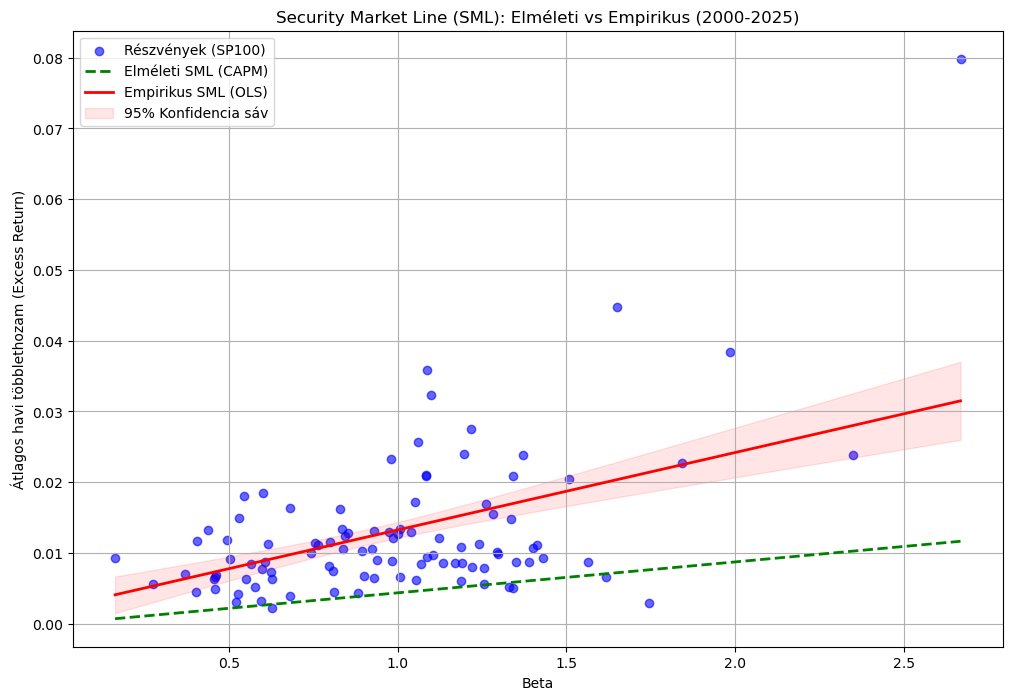

In [109]:
# ---------------------------------------------------------
# 6. SML ÁBRA (Elméleti vs Empirikus) - MÓDOSÍTOTT VERZIÓ
# RÉSZVÉNYNÉVEK NÉLKÜL
# ---------------------------------------------------------

betas = valid_data['beta']
avg_returns = valid_data['riskprem_mean']

# Beta rács a vonalakhoz
beta_grid = np.linspace(betas.min(), betas.max(), 100)

# 1. Elméleti SML: y = 0 + Market_RP * beta
theory_sml = market_rp_mean * beta_grid

# 2. Empirikus SML (a regresszióból): y = gamma0 + gamma1 * beta
X_pred = sm.add_constant(beta_grid)
empirical_sml = model1.predict(X_pred)  # Ez a statsmodels predict függvénye

# Konfidencia intervallum
pred_obj = model1.get_prediction(X_pred)
ci = pred_obj.conf_int()
lower, upper = ci[:, 0], ci[:, 1]

plt.figure(figsize=(12, 8))

# Pontok (Részvények)
plt.scatter(betas, avg_returns, color='blue', alpha=0.6, label='Részvények (SP100)')

# Elméleti SML
plt.plot(beta_grid, theory_sml, color='green', linestyle='--', linewidth=2, label='Elméleti SML (CAPM)')

# Empirikus SML
plt.plot(beta_grid, empirical_sml, color='red', linewidth=2, label='Empirikus SML (OLS)')
plt.fill_between(beta_grid, lower, upper, color='red', alpha=0.1, label='95% Konfidencia sáv')

# Feliratok néhány szélsőséges értékhez - KOMMENTEZVE
# for ticker in betas.index:
#     if betas[ticker] > 1.8 or betas[ticker] < 0.4 or avg_returns[ticker] > 0.025 or avg_returns[ticker] < -0.005:
#         plt.text(betas[ticker], avg_returns[ticker], ticker, fontsize=9, ha='right')

plt.title('Security Market Line (SML): Elméleti vs Empirikus (2000-2025)')
plt.xlabel('Beta')
plt.ylabel('Átlagos havi többlethozam (Excess Return)')
plt.legend()
plt.grid(True)
plt.show()


### 2. Feladat

Robusztusságvizsgálat indítása (Módosított időablakokkal)...


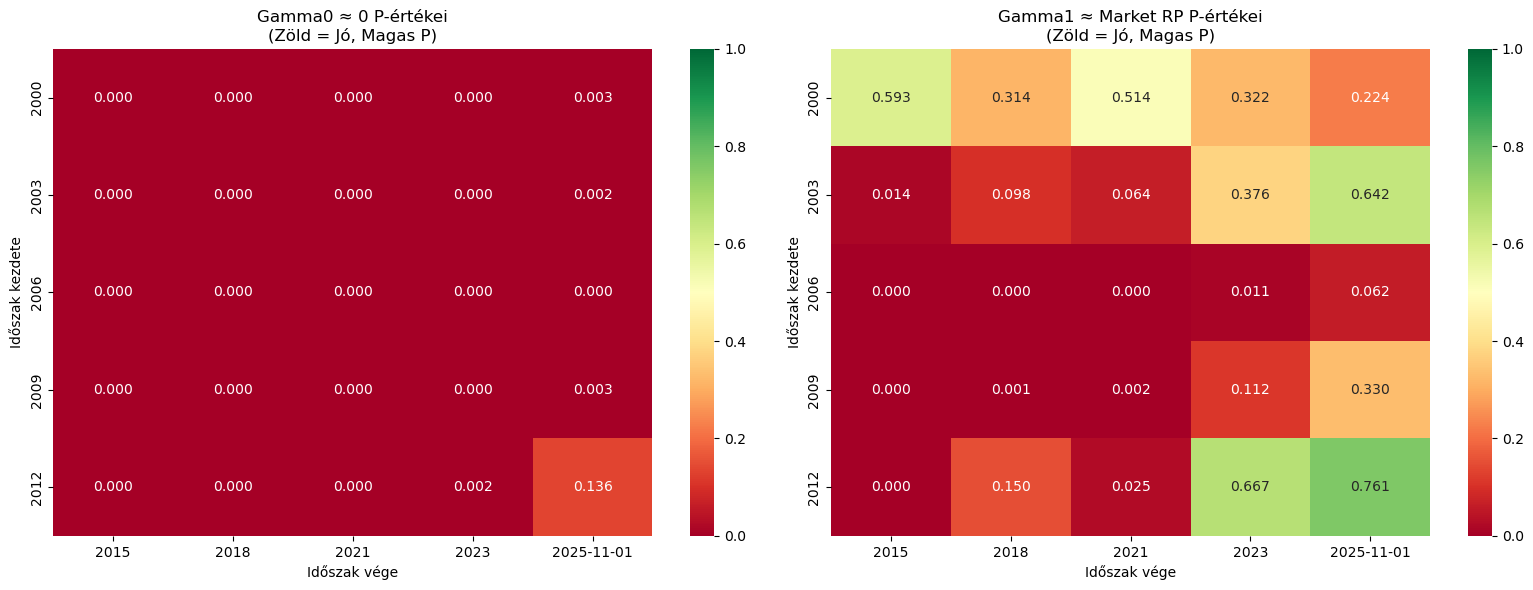

In [62]:
# ---------------------------------------------------------
# 2. FELADAT: ROBUSZTUSSÁG - IDŐBELI ÉRZÉKENYSÉG (JAVÍTOTT)
# ---------------------------------------------------------
print("Robusztusságvizsgálat indítása (Módosított időablakokkal)...")

# Olyan dátumokat választunk, hogy MINDEN kombináció érvényes legyen (ne legyen fehér cella)
# A legkésőbbi start (2012) is korábbi, mint a legkorábbi end (2015)
starts = [
    "2000-01-01",
    "2003-01-01",
    "2006-01-01",
    "2009-01-01",
    "2012-01-01"
]

# Az utolsó dátum a kérésednek megfelelően a friss: 2025.11.01
ends = [
    "2015-01-01",
    "2018-01-01",
    "2021-01-01",
    "2023-01-01",
    "2025-11-01" 
]

# Mátrixok előkészítése a p-értékek tárolására
n_rows = len(starts)
n_cols = len(ends)
pvals_gamma0 = np.zeros((n_rows, n_cols))
pvals_gamma1 = np.zeros((n_rows, n_cols))

market_col = 'SP100_rp'

for i, s in enumerate(starts):
    for j, e in enumerate(ends):
        # Mivel a listákat úgy állítottuk össze, hogy Start < End mindig,
        # itt nem kell NaN ellenőrzés, minden cella számolható lesz.
            
        # 1. First Pass (Beták becslése) - RP_aligned használatával!
        try:
            current_pass = excel_first_pass(RP_aligned, s, e)
            
            if len(current_pass) < 10:
                pvals_gamma0[i,j] = np.nan
                pvals_gamma1[i,j] = np.nan
                continue

            # 2. Second Pass (Keresztmetszeti regresszió)
            valid = current_pass.set_index('Ticker')
            y = valid['riskprem_mean']
            X = sm.add_constant(valid[['beta']])
            
            model = sm.OLS(y, X).fit()
            
            # 3. Hipotézis tesztek
            actual_mkt_rp = RP_aligned[market_col].loc[s:e].mean()
            n_obs = len(valid)
            df = n_obs - 2
            
            # Gamma0 teszt (H0: intercept = 0)
            p_g0 = model.pvalues['const']
            
            # Gamma1 teszt (H0: slope = Market RP)
            gamma1 = model.params['beta']
            se_g1 = model.bse['beta']
            t_stat = (gamma1 - actual_mkt_rp) / se_g1
            p_g1 = 2 * (1 - tdist.cdf(abs(t_stat), df))
            
            pvals_gamma0[i,j] = p_g0
            pvals_gamma1[i,j] = p_g1
            
        except Exception as err:
            print(f"Hiba: {s} -> {e}: {err}")
            pvals_gamma0[i,j] = np.nan
            pvals_gamma1[i,j] = np.nan

# --- HŐTÉRKÉPEK (HEATMAP) ---
def plot_robustness_heatmap(data, title, ax):
    # Formázzuk a címkéket, hogy olvashatóbbak legyenek (pl. 2025.11.01)
    x_labels = [d[:10] if "2025" in d else d[:4] for d in ends]
    y_labels = [d[:4] for d in starts]
    
    sns.heatmap(data, annot=True, fmt=".3f", cmap="RdYlGn", 
                xticklabels=x_labels, 
                yticklabels=y_labels,
                ax=ax, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_xlabel("Időszak vége")
    ax.set_ylabel("Időszak kezdete")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_robustness_heatmap(pvals_gamma0, "Gamma0 ≈ 0 P-értékei\n(Zöld = Jó, Magas P)", axes[0])
plot_robustness_heatmap(pvals_gamma1, "Gamma1 ≈ Market RP P-értékei\n(Zöld = Jó, Magas P)", axes[1])

plt.tight_layout()
plt.show()

Robusztusságvizsgálat: MODELL 2 (Idioszinkratikus kockázat hatása)...


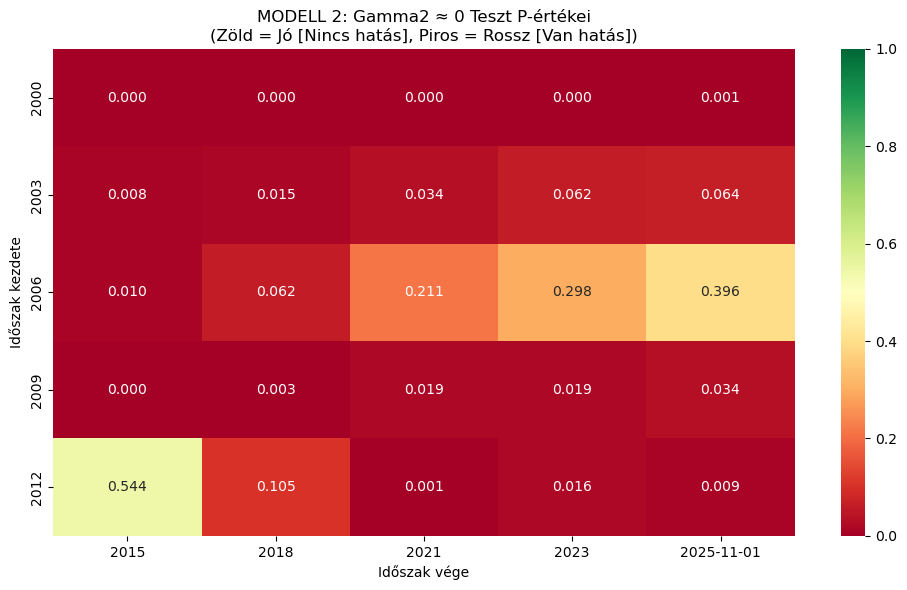

Értelmezés a 2. Modellhez:
- Zöld mezők (p > 0.05): A CAPM JÓL teljesít. Az egyedi kockázatnak (Sigma^2) nincs szignifikáns hatása a hozamra.
- Piros mezők (p < 0.05): A CAPM NEM teljesül. Az egyedi kockázatot is árazza a piac, ami ellentmond az elméletnek.


In [17]:
# ---------------------------------------------------------
# 2. FELADAT: ROBUSZTUSSÁG - MODELL 2 (Gamma2 Teszt)
# ---------------------------------------------------------
print("Robusztusságvizsgálat: MODELL 2 (Idioszinkratikus kockázat hatása)...")

# Ugyanazok az időablakok, mint az előbb
starts = [
    "2000-01-01",
    "2003-01-01",
    "2006-01-01",
    "2009-01-01",
    "2012-01-01"
]

ends = [
    "2015-01-01",
    "2018-01-01",
    "2021-01-01",
    "2023-01-01",
    "2025-11-01" 
]

n_rows = len(starts)
n_cols = len(ends)
pvals_gamma2 = np.zeros((n_rows, n_cols)) # Csak a Gamma2-t vizsgáljuk most

for i, s in enumerate(starts):
    for j, e in enumerate(ends):
        try:
            # 1. First Pass
            current_pass = excel_first_pass(RP_aligned, s, e)
            
            if len(current_pass) < 10:
                pvals_gamma2[i,j] = np.nan
                continue

            # 2. Second Pass (MODELL 2: Beta + Sigma2)
            valid = current_pass.set_index('Ticker')
            y = valid['riskprem_mean']
            # Itt hozzáadjuk a sigma2-t is a magyarázó változókhoz
            X = sm.add_constant(valid[['beta', 'sigma2']]) 
            
            model2 = sm.OLS(y, X).fit()
            
            # 3. Hipotézis teszt: Gamma2 = 0?
            # Ha p > 0.05, akkor elfogadjuk, hogy 0 (ami JÓ a CAPM-nek)
            # Ha p < 0.05, akkor szignifikáns (ami ROSSZ, mert számít az egyedi kockázat)
            p_g2 = model2.pvalues['sigma2']
            
            pvals_gamma2[i,j] = p_g2
            
        except Exception as err:
            print(f"Hiba: {s} -> {e}: {err}")
            pvals_gamma2[i,j] = np.nan

# --- HŐTÉRKÉP KIRAJZOLÁSA ---
plt.figure(figsize=(10, 6))

# Címkék formázása
x_labels = [d[:10] if "2025" in d else d[:4] for d in ends]
y_labels = [d[:4] for d in starts]

# Heatmap
# Itt is a ZÖLD a jó (magas p-érték => nincs hatása a sigma2-nek)
# A PIROS a rossz (alacsony p-érték => van hatása, "szétesik" a CAPM)
sns.heatmap(pvals_gamma2, annot=True, fmt=".3f", cmap="RdYlGn", 
            xticklabels=x_labels, 
            yticklabels=y_labels,
            vmin=0, vmax=1)

plt.title("MODELL 2: Gamma2 ≈ 0 Teszt P-értékei\n(Zöld = Jó [Nincs hatás], Piros = Rossz [Van hatás])")
plt.xlabel("Időszak vége")
plt.ylabel("Időszak kezdete")
plt.tight_layout()
plt.show()

print("Értelmezés a 2. Modellhez:")
print("- Zöld mezők (p > 0.05): A CAPM JÓL teljesít. Az egyedi kockázatnak (Sigma^2) nincs szignifikáns hatása a hozamra.")
print("- Piros mezők (p < 0.05): A CAPM NEM teljesül. Az egyedi kockázatot is árazza a piac, ami ellentmond az elméletnek.")

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import t as tdist

print("=== HETI CAPM: SZIGORÚ SZŰRÉS (2000-2025) ===")

# 1. ADATOK BETÖLTÉSE
stock_ret = pd.read_csv('weekly_stock_returns.csv', index_col=0, parse_dates=True)
market_ret = pd.read_csv('weekly_market_returns.csv', index_col=0, parse_dates=True)
rf_rate = pd.read_csv('weekly_risk_free_rate.csv', index_col=0, parse_dates=True)

# 2. IDŐSZAK BEÁLLÍTÁSA
start_date = '2000-01-01'
end_date = '2025-11-01'

stock_ret = stock_ret.loc[start_date:end_date]
market_ret = market_ret.loc[start_date:end_date]
rf_rate = rf_rate.loc[start_date:end_date]

print(f"Vizsgált időszak: {start_date} - {end_date}")

# --- JAVÍTÁS: Üres sorok törlése ---
# Ez a lépés oldja meg a problémát! Ha van olyan hét (pl. 2000-01-07), 
# ahol MINDENKI hiányzik, azt a hetet kivesszük, nem a részvényeket.
stock_ret = stock_ret.dropna(axis=0, how='all')

# 3. SZIGORÚ OSZLOP SZŰRÉS (A Te kérésed)
# Most már csak azokat dobjuk ki, akik tényleg nem léteztek végig
stock_ret = stock_ret.dropna(axis=1, how='any')

print(f"Megmaradt (elemzésre kész) részvények száma: {stock_ret.shape[1]}")

if stock_ret.shape[1] > 0:
    print(f"Példa megmaradt részvényekre: {', '.join(stock_ret.columns[:5])}...")
    
    # 4. ÖSSZEIGAZÍTÁS
    data = pd.concat([stock_ret, market_ret, rf_rate], axis=1).dropna()
    
    stocks = stock_ret.columns
    RP_aligned = data[stocks].sub(data[rf_rate.columns[0]], axis=0)
    RP_aligned['SP500_rp'] = data[market_ret.columns[0]] - data[rf_rate.columns[0]]
    
    # 5. FIRST PASS (Idősoros regresszió)
    betas = []
    avg_excess_ret = []
    var_residuals = []
    X = sm.add_constant(RP_aligned['SP500_rp'])
    
    for stock in stocks:
        y = RP_aligned[stock]
        model = sm.OLS(y, X).fit()
        betas.append(model.params['SP500_rp'])
        avg_excess_ret.append(y.mean())
        var_residuals.append(model.mse_resid)
        
    sec_pass_data = pd.DataFrame({
        'Mean_Excess_Ret': avg_excess_ret,
        'beta': betas,
        'sigma2': var_residuals
    }, index=stocks)
    
    # 6. SECOND PASS (Keresztmetszeti regresszió)
    market_rp_mean = RP_aligned['SP500_rp'].mean() # Heti átlag
    n_obs = len(sec_pass_data)
    df1 = n_obs - 2
    alpha = 0.05
    
    # Model 1: Csak Beta
    X1 = sm.add_constant(sec_pass_data['beta'])
    model1 = sm.OLS(sec_pass_data['Mean_Excess_Ret'], X1).fit()
    
    # Model 2: Beta + Sigma^2
    X2 = sm.add_constant(sec_pass_data[['beta', 'sigma2']])
    model2 = sm.OLS(sec_pass_data['Mean_Excess_Ret'], X2).fit()
    
    # --- RÉSZLETES HIPOTÉZIS TESZT TÁBLÁZAT (MINT A HAVINÁL) ---
    print('\n=== CAPM RÉSZLETES EREDMÉNYEK (GAMMÁK) ===')
    print(f"Vizsgált Piaci Prémium (Heti átlag): {market_rp_mean:.4f} ({market_rp_mean:.2%})")
    
    # A) Gamma 0 (Intercept) - Model 1
    # H0: gamma0 = 0
    gamma0 = model1.params['const']
    t_stat_gamma0 = model1.tvalues['const']
    p_val_gamma0 = model1.pvalues['const']
    res_gamma0 = "Megfelel" if p_val_gamma0 >= alpha else "Nem felel meg"

    # B) Gamma 1 (Slope) - Model 1
    # H0: gamma1 = Market RP
    gamma1 = model1.params['beta']
    se_gamma1 = model1.bse['beta']
    t_stat_gamma1 = (gamma1 - market_rp_mean) / se_gamma1
    p_val_gamma1 = 2 * (1 - tdist.cdf(abs(t_stat_gamma1), df1))
    res_gamma1 = "Megfelel" if p_val_gamma1 >= alpha else "Nem felel meg"

    # C) Gamma 2 (Sigma^2) - Model 2
    # H0: gamma2 = 0
    gamma2 = model2.params['sigma2']
    t_stat_gamma2 = model2.tvalues['sigma2']
    p_val_gamma2 = model2.pvalues['sigma2']
    res_gamma2 = "Megfelel" if p_val_gamma2 >= alpha else "Nem felel meg"

    results_list = [
        {
            "Modell": "1. (Csak Beta)",
            "Paraméter": "Intercept (γ0)",
            "Nullhipotézis (H0)": "γ0 = 0",
            "Becsült Érték": gamma0,
            "Elméleti Érték": 0.0,
            "t-statisztika": t_stat_gamma0,
            "p-érték": p_val_gamma0,
            "Döntés": res_gamma0
        },
        {
            "Modell": "1. (Csak Beta)",
            "Paraméter": "Slope (γ1)",
            "Nullhipotézis (H0)": "γ1 = Market RP",
            "Becsült Érték": gamma1,
            "Elméleti Érték": market_rp_mean,
            "t-statisztika": t_stat_gamma1,
            "p-érték": p_val_gamma1,
            "Döntés": res_gamma1
        },
        {
            "Modell": "2. (Bővített)",
            "Paraméter": "Sigma^2 (γ2)",
            "Nullhipotézis (H0)": "γ2 = 0",
            "Becsült Érték": gamma2,
            "Elméleti Érték": 0.0,
            "t-statisztika": t_stat_gamma2,
            "p-érték": p_val_gamma2,
            "Döntés": res_gamma2
        }
    ]

    df_res = pd.DataFrame(results_list)
    pd.options.display.float_format = '{:.4f}'.format
    print(df_res.to_string(index=False))
    
    # Rövid szöveges értékelés
    print("-" * 100)
    if res_gamma1 == "Megfelel":
        print("SIKER: A modell kockázati prémiuma statisztikailag megegyezik a piaci átlaggal.")
    else:
        print("FIGYELEM: A modell által becsült kockázati prémium eltér a piactól.")

else:
    print("SAJNOS: 0 db részvény maradt.")
    print("Ez azt jelenti, hogy még az üres sorok törlése után is minden részvénynél volt hiány.")
    print("Javaslat: Válassz későbbi kezdő dátumot (pl. 2012), hogy több részvényed maradjon.")

=== HETI CAPM: SZIGORÚ SZŰRÉS (2000-2025) ===
Vizsgált időszak: 2000-01-01 - 2025-11-01
Megmaradt (elemzésre kész) részvények száma: 80
Példa megmaradt részvényekre: AAPL, ABT, ADBE, AIG, AMD...

=== CAPM RÉSZLETES EREDMÉNYEK (GAMMÁK) ===
Vizsgált Piaci Prémium (Heti átlag): 0.0010 (0.10%)
        Modell      Paraméter Nullhipotézis (H0)  Becsült Érték  Elméleti Érték  t-statisztika  p-érték        Döntés
1. (Csak Beta) Intercept (γ0)             γ0 = 0         0.0009          0.0000         2.1871   0.0317 Nem felel meg
1. (Csak Beta)     Slope (γ1)     γ1 = Market RP         0.0016          0.0010         1.5059   0.1361      Megfelel
 2. (Bővített)   Sigma^2 (γ2)             γ2 = 0         0.5495          0.0000         3.9455   0.0002 Nem felel meg
----------------------------------------------------------------------------------------------------
SIKER: A modell kockázati prémiuma statisztikailag megegyezik a piaci átlaggal.


In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import t as tdist

print("=================================================================")
print("       NAPI (DAILY) CAPM - TELJES IDŐSZAK + SZIGORÚ SZŰRÉS")
print("=================================================================")

# 1. ADATOK BETÖLTÉSE
try:
    stock_ret = pd.read_csv('daily_stock_returns.csv', index_col=0, parse_dates=True)
    market_ret = pd.read_csv('daily_market_returns.csv', index_col=0, parse_dates=True)
    rf_rate = pd.read_csv('daily_risk_free_rate.csv', index_col=0, parse_dates=True)
except FileNotFoundError as e:
    print(f"\nHIBA: Nem találom a fájlokat! ({e})")
    raise

print(f"Eredeti adatbázis mérete: {len(stock_ret)} nap")

# 2. ADATTISZTÍTÁS (A Te kérésed szerint: Szigorú)
# A) Üres SOROK eltávolítása (pl. az első sor)
stock_ret = stock_ret.dropna(axis=0, how='all')
market_ret = market_ret.dropna(axis=0, how='all')
rf_rate = rf_rate.dropna(axis=0, how='all')

# B) Oszlopok (Részvények) szűrése - Aki hiányos, kiesik
stock_ret = stock_ret.dropna(axis=1, how='any')

print(f"Tisztítás utáni részvények száma: {stock_ret.shape[1]}")
print(f"Elemzett napok száma: {len(stock_ret)}")

if stock_ret.shape[1] > 0:
    # 3. ÖSSZEIGAZÍTÁS
    data = pd.concat([stock_ret, market_ret, rf_rate], axis=1).dropna()
    
    stocks = stock_ret.columns
    # Excess Return számítása
    RP_aligned = data[stocks].sub(data[rf_rate.columns[0]], axis=0)
    RP_aligned['Market_RP'] = data[market_ret.columns[0]] - data[rf_rate.columns[0]]
    
    # 4. FIRST PASS (Idősoros Regresszió)
    print("\n>>> First Pass regressziók futtatása...")
    betas = []
    avg_excess_ret = []
    var_residuals = []
    
    X = sm.add_constant(RP_aligned['Market_RP'])
    
    for stock in stocks:
        y = RP_aligned[stock]
        model = sm.OLS(y, X).fit()
        betas.append(model.params['Market_RP'])
        avg_excess_ret.append(y.mean())
        var_residuals.append(model.mse_resid)
        
    sec_pass_data = pd.DataFrame({
        'Mean_Excess_Ret': avg_excess_ret,
        'beta': betas,
        'sigma2': var_residuals
    }, index=stocks)
    
    # 5. SECOND PASS (Keresztmetszeti Regresszió)
    print(">>> Second Pass regressziók futtatása...")
    
    market_rp_mean = RP_aligned['Market_RP'].mean()
    n_obs = len(sec_pass_data)
    df1 = n_obs - 2
    alpha = 0.05
    
    # Model 1: Csak Beta
    X1 = sm.add_constant(sec_pass_data['beta'])
    model1 = sm.OLS(sec_pass_data['Mean_Excess_Ret'], X1).fit()
    
    # Model 2: Beta + Sigma^2
    X2 = sm.add_constant(sec_pass_data[['beta', 'sigma2']])
    model2 = sm.OLS(sec_pass_data['Mean_Excess_Ret'], X2).fit()
    
    # 6. EREDMÉNYEK ÉS TÁBLÁZAT
    
    # --- Model 1 Paraméterek ---
    gamma0_1 = model1.params['const']
    # HIÁNYZÓ SOR PÓTOLVA:
    t_stat_gamma0_1 = model1.tvalues['const'] 
    p_gamma0_1 = model1.pvalues['const']
    
    gamma1_1 = model1.params['beta']
    se_gamma1_1 = model1.bse['beta']
    t_stat_gamma1_1 = (gamma1_1 - market_rp_mean) / se_gamma1_1
    p_val_gamma1_1 = 2 * (1 - tdist.cdf(abs(t_stat_gamma1_1), df1))
    
    # --- Model 2 Paraméterek ---
    gamma2_2 = model2.params['sigma2']
    t_stat_gamma2_2 = model2.tvalues['sigma2']
    p_val_gamma2_2 = model2.pvalues['sigma2']
    
    # Döntések
    dec_g0 = "Megfelel" if p_gamma0_1 >= alpha else "Nem felel meg"
    dec_g1 = "Megfelel" if p_val_gamma1_1 >= alpha else "Nem felel meg"
    dec_g2 = "Megfelel" if p_val_gamma2_2 >= alpha else "Nem felel meg"

    print('\n=== CAPM EREDMÉNYEK ÖSSZEFOGLALÁSA (NAPI ADATOK) ===')
    print(f"Vizsgált időszak: {RP_aligned.index.min().date()} - {RP_aligned.index.max().date()}")
    print(f"Piaci kockázati prémium átlaga (H0): {market_rp_mean:.6f} (napi) / {market_rp_mean*252:.4f} (évesítve)")
    print("-" * 100)
    
    results_list = [
        {
            "Modell": "1. (Csak Beta)",
            "Paraméter": "Intercept (γ0)",
            "Nullhipotézis (H0)": "γ0 = 0",
            "Becsült Érték": gamma0_1,
            "Elméleti Érték": 0.0,
            "t-statisztika": t_stat_gamma0_1,
            "p-érték": p_gamma0_1,
            "Eredmény": dec_g0
        },
        {
            "Modell": "1. (Csak Beta)",
            "Paraméter": "Slope (γ1)",
            "Nullhipotézis (H0)": "γ1 = Market RP",
            "Becsült Érték": gamma1_1,
            "Elméleti Érték": market_rp_mean,
            "t-statisztika": t_stat_gamma1_1,
            "p-érték": p_val_gamma1_1,
            "Eredmény": dec_g1
        },
        {
            "Modell": "2. (Bővített)",
            "Paraméter": "Sigma^2 (γ2)",
            "Nullhipotézis (H0)": "γ2 = 0",
            "Becsült Érték": gamma2_2,
            "Elméleti Érték": 0.0,
            "t-statisztika": t_stat_gamma2_2,
            "p-érték": p_val_gamma2_2,
            "Eredmény": dec_g2
        }
    ]

    df_res = pd.DataFrame(results_list)
    pd.options.display.float_format = '{:.6f}'.format
    print(df_res.to_string(index=False))
    print("-" * 100)
    
    # Gyors kiértékelés
    print("ÉRTELMEZÉS:")
    if dec_g1 == "Megfelel":
        print(" -> SIKER: A modell által becsült kockázati prémium (Slope) statisztikailag megegyezik a piaci átlaggal.")
    else:
        print(" -> ELTÉRÉS: A modell kockázati prémiuma szignifikánsan eltér a piactól.")
        
    if dec_g2 == "Megfelel":
        print(" -> SIKER: Az egyedi kockázat (Sigma^2) nem szignifikáns tényező (CAPM teljesül).")
    else:
        print(" -> ELTÉRÉS: A piac az egyedi kockázatot is árazza (CAPM sérül).")

else:
    print("SAJNOS: 0 db részvény maradt a szűrés után.")

       NAPI (DAILY) CAPM - TELJES IDŐSZAK + SZIGORÚ SZŰRÉS
Eredeti adatbázis mérete: 6498 nap
Tisztítás utáni részvények száma: 80
Elemzett napok száma: 6497

>>> First Pass regressziók futtatása...
>>> Second Pass regressziók futtatása...

=== CAPM EREDMÉNYEK ÖSSZEFOGLALÁSA (NAPI ADATOK) ===
Vizsgált időszak: 2000-01-04 - 2025-10-31
Piaci kockázati prémium átlaga (H0): 0.000209 (napi) / 0.0527 (évesítve)
----------------------------------------------------------------------------------------------------
        Modell      Paraméter Nullhipotézis (H0)  Becsült Érték  Elméleti Érték  t-statisztika  p-érték      Eredmény
1. (Csak Beta) Intercept (γ0)             γ0 = 0       0.000204        0.000000       2.472942 0.015576 Nem felel meg
1. (Csak Beta)     Slope (γ1)     γ1 = Market RP       0.000308        0.000209       1.207056 0.231058      Megfelel
 2. (Bővített)   Sigma^2 (γ2)             γ2 = 0       0.698016        0.000000       4.700322 0.000011 Nem felel meg
------------------

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import t as tdist

# =============================================================================
# 1. ELEMZŐ FÜGGVÉNY (MODEL 2: Beta + Sigma^2)
# =============================================================================
def analyze_capm_model2(freq_name, stock_file, market_file, rf_file):
    """
    Lefuttatja a CAPM Model 2 elemzést (Beta és Sigma^2) a megadott fájlokon.
    Visszatér egy szótárral (eredménysor) vagy None-nal hiba esetén.
    """
    print(f"--- {freq_name} adatok feldolgozása... ---")
    try:
        # Adatok betöltése
        stock_ret = pd.read_csv(stock_file, index_col=0, parse_dates=True)
        market_ret = pd.read_csv(market_file, index_col=0, parse_dates=True)
        rf_rate = pd.read_csv(rf_file, index_col=0, parse_dates=True)

        # 1. Időszak szűrése (2000-2025)
        start_date = '2000-01-01'
        end_date = '2025-11-01'
        stock_ret = stock_ret.loc[start_date:end_date]
        market_ret = market_ret.loc[start_date:end_date]
        rf_rate = rf_rate.loc[start_date:end_date]

        # 2. Tisztítás (Szigorú)
        # Üres sorok törlése (pl. első sor)
        stock_ret = stock_ret.dropna(axis=0, how='all')
        
        # Szigorú oszlopszűrés: Csak a teljes adatsorral rendelkező részvények maradnak
        stock_ret = stock_ret.dropna(axis=1, how='any')
        
        n_stocks = stock_ret.shape[1]
        if n_stocks == 0:
            print(f"HIBA: Nincs elegendő adat a {freq_name} frekvencián (0 részvény maradt).")
            return None

        # 3. Összeigazítás
        data = pd.concat([stock_ret, market_ret, rf_rate], axis=1).dropna()
        stocks = stock_ret.columns
        
        market_col = market_ret.columns[0]
        rf_col = rf_rate.columns[0]

        # 4. Excess Return számítása
        # Részvények többlethozama (Ri - Rf)
        RP_aligned = data[stocks].sub(data[rf_col], axis=0)
        # Tényleges Piaci Prémium (Rm - Rf)
        RP_aligned['Market_RP'] = data[market_col] - data[rf_col]

        # 5. First Pass Regresszió (Idősoros)
        betas = []
        avg_excess_ret = []
        var_residuals = [] # Sigma^2 (Nem-szisztematikus kockázat)
        
        X = sm.add_constant(RP_aligned['Market_RP'])
        
        for stock in stocks:
            y = RP_aligned[stock]
            model = sm.OLS(y, X).fit()
            betas.append(model.params['Market_RP'])
            avg_excess_ret.append(y.mean())
            var_residuals.append(model.mse_resid)
            
        sec_pass_data = pd.DataFrame({
            'Mean_Excess_Ret': avg_excess_ret,
            'beta': betas,
            'sigma2': var_residuals
        }, index=stocks)

        # 6. Second Pass Regresszió (Keresztmetszeti) - CSAK MODEL 2
        # Egyenlet: Ri_átlag = gamma0 + gamma1 * beta + gamma2 * sigma^2
        market_rp_mean = RP_aligned['Market_RP'].mean() # H0 érték a piacról
        n_obs = len(sec_pass_data)
        
        X2 = sm.add_constant(sec_pass_data[['beta', 'sigma2']])
        model2 = sm.OLS(sec_pass_data['Mean_Excess_Ret'], X2).fit()
        
        # 7. Eredmények kinyerése
        # Gamma 0 (Konstans)
        g0 = model2.params['const']
        p_g0 = model2.pvalues['const']
        
        # Gamma 1 (Slope) - A H0 itt az, hogy g1 == Piaci RP
        g1 = model2.params['beta']
        se_g1 = model2.bse['beta']
        t_g1 = (g1 - market_rp_mean) / se_g1
        df = n_obs - 3
        p_g1_vs_mrp = 2 * (1 - tdist.cdf(abs(t_g1), df))
        
        # Gamma 2 (Sigma^2) - A H0 itt az, hogy g2 == 0
        g2 = model2.params['sigma2']
        p_g2 = model2.pvalues['sigma2']

        return {
            'Frekvencia': freq_name,
            'N (Részvények)': n_stocks,
            'T (Időszak)': len(RP_aligned),
            'Piaci RP (H0)': market_rp_mean,
            'Gamma 0': g0,
            'p(g0=0)': p_g0,
            'Gamma 1': g1,
            'p(g1=MRP)': p_g1_vs_mrp,
            'Gamma 2': g2,
            'p(g2=0)': p_g2
        }

    except Exception as e:
        print(f"KIVÉTEL történt a {freq_name} feldolgozása közben: {e}")
        return None

# =============================================================================
# 2. FUTTATÁS MINDEN FREKVENCIÁRA
# =============================================================================
results = []

# Itt add meg a fájlneveidet, ha eltérnének!
files = [
    ('Havi', 'monthly_stock_returns.csv', 'monthly_market_returns.csv', 'monthly_risk_free_rate.csv'),
    ('Heti', 'weekly_stock_returns.csv', 'weekly_market_returns.csv', 'weekly_risk_free_rate.csv'),
    ('Napi', 'daily_stock_returns.csv', 'daily_market_returns.csv', 'daily_risk_free_rate.csv')
]

for name, s_file, m_file, rf_file in files:
    res = analyze_capm_model2(name, s_file, m_file, rf_file)
    if res:
        results.append(res)

# =============================================================================
# 3. EREDMÉNYEK TÁBLÁZATBA RENDEZÉSE
# =============================================================================
if results:
    df_results = pd.DataFrame(results)

    # Formázás beállítása (6 tizedesjegy a kis számok miatt)
    pd.options.display.float_format = '{:.6f}'.format
    
    print("\n" + "="*100)
    print("      ÖSSZESÍTŐ TÁBLÁZAT (MODEL 2: Beta + Sigma^2)")
    print("="*100)
    
    # Oszlopok sorrendje
    cols = [
        'Frekvencia', 'N (Részvények)', 'T (Időszak)', 'Piaci RP (H0)',
        'Gamma 0', 'p(g0=0)', 
        'Gamma 1', 'p(g1=MRP)', 
        'Gamma 2', 'p(g2=0)'
    ]
    
    print(df_results[cols].to_string(index=False))
    print("-" * 100)
    print("Jelmagyarázat:")
    print("p(g1=MRP) > 0.05 -> JÓ (A becsült kockázati prémium megegyezik a piaci átlaggal).")
    print("p(g2=0) < 0.05   -> ROSSZ (Az egyedi kockázat is árazódik).")
else:
    print("Nem sikerült eredményeket generálni (ellenőrizd a fájlneveket).")

--- Havi adatok feldolgozása... ---
--- Heti adatok feldolgozása... ---
--- Napi adatok feldolgozása... ---

      ÖSSZESÍTŐ TÁBLÁZAT (MODEL 2: Beta + Sigma^2)
Frekvencia  N (Részvények)  T (Időszak)  Piaci RP (H0)  Gamma 0  p(g0=0)  Gamma 1  p(g1=MRP)  Gamma 2  p(g2=0)
      Havi              80          309       0.004371 0.005129 0.000275 0.002665   0.290383 0.416464 0.000727
      Heti              80         1347       0.001049 0.001190 0.001758 0.000452   0.193176 0.549531 0.000175
      Napi              80         6450       0.000209 0.000271 0.000508 0.000021   0.050997 0.698016 0.000011
----------------------------------------------------------------------------------------------------
Jelmagyarázat:
p(g1=MRP) > 0.05 -> JÓ (A becsült kockázati prémium megegyezik a piaci átlaggal).
p(g2=0) < 0.05   -> ROSSZ (Az egyedi kockázat is árazódik).


### AI

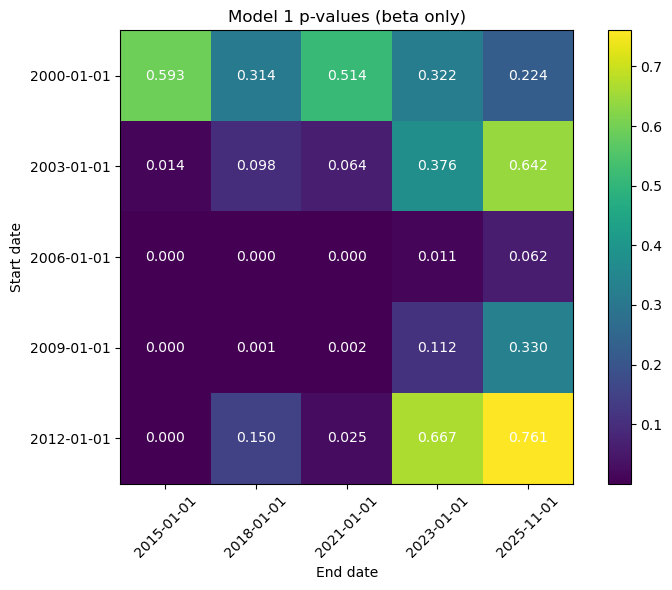

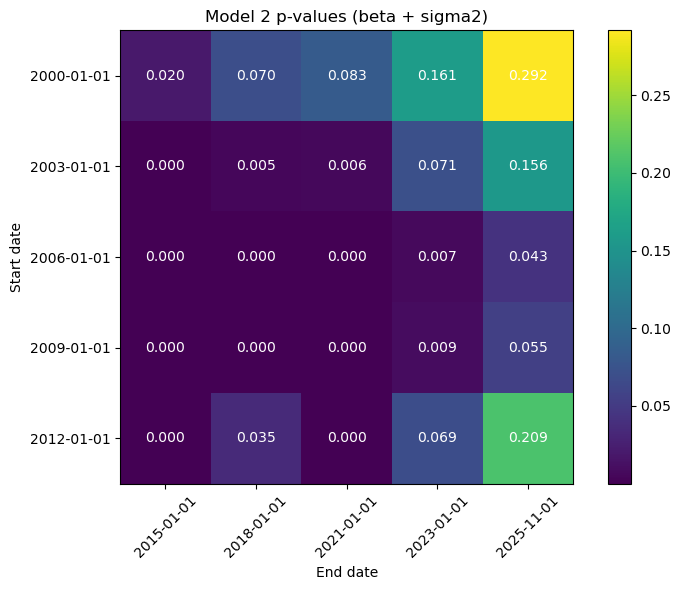

In [73]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import t as tdist

# Az 1. FELADATODBÓL már van: RP_aligned

def excel_first_pass(RP, start, end, market_col='SP100_rp'):
    RPsub = RP.loc[start:end]
    RM = RPsub[market_col]
    rows = []
    for s in RPsub.columns:
        if s == market_col: continue
        Ri = RPsub[s]
        cov = np.cov(Ri, RM)[0,1]
        var = np.var(RM, ddof=1)
        beta = cov/var
        alpha = Ri.mean() - beta*RM.mean()
        sigma2 = np.var(Ri - beta*RM)
        rows.append([s, beta, alpha, sigma2, Ri.mean()])
    return pd.DataFrame(rows, columns=['Ticker','beta','alpha','sigma2','riskprem_mean'])

starts = [
    "2000-01-01",
    "2003-01-01",
    "2006-01-01",
    "2009-01-01",
    "2012-01-01"
]

ends = [
    "2015-01-01",
    "2018-01-01",
    "2021-01-01",
    "2023-01-01",
    "2025-11-01" 
]

pvals1 = np.zeros((5,5))
pvals2 = np.zeros((5,5))

for i, s in enumerate(starts):
    for j, e in enumerate(ends):
        first = excel_first_pass(RP_aligned, s, e, market_col='SP100_rp')
        valid = first.set_index('Ticker').dropna()
        y = valid['riskprem_mean']
        
        X1 = sm.add_constant(valid[['beta']])
        model1 = sm.OLS(y, X1).fit()
        
        X2 = sm.add_constant(valid[['beta','sigma2']])
        model2 = sm.OLS(y, X2).fit()
        
        market_rp = RP_aligned['SP100_rp'].loc[s:e].mean()
        n = valid.shape[0]
        
        gamma1_1 = model1.params['beta']
        se1 = model1.bse['beta']
        t1 = (gamma1_1 - market_rp)/se1
        p1 = 2*(1 - tdist.cdf(abs(t1), n-2))
        
        gamma1_2 = model2.params['beta']
        se2 = model2.bse['beta']
        t2 = (gamma1_2 - market_rp)/se2
        p2 = 2*(1 - tdist.cdf(abs(t2), n-3))
        
        pvals1[i,j] = p1
        pvals2[i,j] = p2

def plot_heatmap(mat, title):
    plt.figure(figsize=(8,6))
    im = plt.imshow(mat, cmap='viridis')
    plt.colorbar(im)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(j, i, f'{mat[i,j]:.3f}', ha='center', va='center', color='white')
    plt.title(title)
    plt.xticks(range(5), [e[:10] for e in ends], rotation=45)
    plt.yticks(range(5), [s[:10] for s in starts])
    plt.xlabel("End date")
    plt.ylabel("Start date")
    plt.tight_layout()
    plt.show()

plot_heatmap(pvals1, "Model 1 p-values (beta only)")
plot_heatmap(pvals2, "Model 2 p-values (beta + sigma2)")


In [41]:
# =============================================================================
# 2.B RÉSZ: FREKVENCIA-ÖSSZEHASONLÍTÁS (HAVI, HETI, NAPI ADATOK)
# =============================================================================

print("\n" + "="*100)
print("2.B: FREKVENCIA-ÖSSZEHASONLÍTÁS (Model 2: Beta + Sigma^2)")
print("="*100)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import t as tdist

def analyze_capm_frequency(name, stock_file, market_file, rf_file):
    """
    CAPM Model 2 (Beta + Sigma²) elemzés adott frekvencián.
    
    Bemenet:
    - name: Frekvencia neve (Havi, Heti, Napi)
    - stock_file, market_file, rf_file: CSV fájlok
    
    Kimenet:
    - Szótár az eredménnyel
    """
    try:
        # 1. ADATOK BETÖLTÉSE
        stock_ret = pd.read_csv(stock_file, index_col=0, parse_dates=True)
        market_ret = pd.read_csv(market_file, index_col=0, parse_dates=True)
        rf_rate = pd.read_csv(rf_file, index_col=0, parse_dates=True)
        
        # 2. IDÕSZAK SZÛKÍTÉSE (2000-2025)
        start_date = "2000-01-01"
        end_date = "2025-11-01"
        
        stock_ret = stock_ret.loc[start_date:end_date]
        market_ret = market_ret.loc[start_date:end_date]
        rf_rate = rf_rate.loc[start_date:end_date]
        
        # 3. ADATTISZTÍTÁS
        # Üres sorok törlése
        stock_ret = stock_ret.dropna(axis=0, how='all')
        
        # SZIGORÚ OSZLOPSZÛRÉS: csak teljes adatsorú részvények
        stock_ret = stock_ret.dropna(axis=1, how='any')
        
        n_stocks = stock_ret.shape[1]
        if n_stocks < 10:
            print(f"⚠ FIGYELEM: {name} - túl kevés részvény ({n_stocks})")
            return None
        
        # 4. ÖSSZEIGAZÍTÁS
        data = pd.concat([stock_ret, market_ret, rf_rate], axis=1).dropna()
        
        stocks = stock_ret.columns
        market_col = market_ret.columns[0]
        rf_col = rf_rate.columns[0]
        
        n_periods = len(data)
        
        # 5. EXCESS RETURNS
        RP_aligned = data[stocks].sub(data[rf_col], axis=0)
        RP_aligned['Market_RP'] = data[market_col] - data[rf_col]
        
        # 6. FIRST PASS: Idsoros regresszió (individual stocks)
        betas = []
        avg_excess_ret = []
        var_residuals = []
        
        X = sm.add_constant(RP_aligned['Market_RP'])
        
        for stock in stocks:
            y = RP_aligned[stock]
            model = sm.OLS(y, X).fit()
            
            betas.append(model.params['Market_RP'])
            avg_excess_ret.append(y.mean())
            
            # JAVÍTÁS: mse_resid helyett scale vagy mse_resid
            # Sigma² = MSE (Mean Squared Error)
            var_residuals.append(model.mse_resid)
        
        # 7. SECOND PASS: Keresztmetszeti regresszió (Model 2)
        sec_pass_data = pd.DataFrame({
            'MeanExcessRet': avg_excess_ret,
            'beta': betas,
            'sigma2': var_residuals
        }, index=stocks)
        
        market_rp_mean = RP_aligned['Market_RP'].mean()
        n_obs = len(sec_pass_data)
        df = n_obs - 3  # 3 paraméter: const, beta, sigma2
        
        # Model 2: Beta + Sigma²
        X2 = sm.add_constant(sec_pass_data[['beta', 'sigma2']])
        model2 = sm.OLS(sec_pass_data['MeanExcessRet'], X2).fit()
        
        # 8. HIPOTÉZIS TESZTEK
        
        # Gamma 0: H0: gamma0 = 0
        g0 = model2.params['const']
        pg0 = model2.pvalues['const']
        
        # Gamma 1: H0: gamma1 = Market_RP
        g1 = model2.params['beta']
        seg1 = model2.bse['beta']
        t_g1 = (g1 - market_rp_mean) / seg1
        pg1_vs_mrp = 2 * (1 - tdist.cdf(abs(t_g1), df))
        
        # Gamma 2: H0: gamma2 = 0 (idioszinkratikus kockázat hatása)
        g2 = model2.params['sigma2']
        pg2 = model2.pvalues['sigma2']
        
        return {
            'Frekvencia': name,
            'N_stocks': n_stocks,
            'N_periods': n_periods,
            'Piaci_RP': market_rp_mean,
            'Gamma_0': g0,
            'p_g0': pg0,
            'Gamma_1': g1,
            'p_g1_vs_MRP': pg1_vs_mrp,
            'Gamma_2': g2,
            'p_g2': pg2,
            'R2_Model2': model2.rsquared
        }
        
    except Exception as e:
        print(f"✗ HIBA {name}: {str(e)}")
        return None


# ============================================================================
# FUTTATÁS MINDHÁROM FREKVENCIÁN
# ============================================================================

print("\n2.B: Frekvencia-összehasonlítás futtatása...\n")

results = []

# Fájl konfigurálás (ellenõrizd az elérési útvonalakat!)
files = [
    ("Havi",  "monthly_stock_returns.csv", "monthly_market_returns.csv", "monthly_risk_free_rate.csv"),
    ("Heti",  "weekly_stock_returns.csv",  "weekly_market_returns.csv",  "weekly_risk_free_rate.csv"),
    ("Napi",  "daily_stock_returns.csv",   "daily_market_returns.csv",   "daily_risk_free_rate.csv")
]

for name, sfile, mfile, rffile in files:
    print(f"Processing {name}...", end=" ")
    res = analyze_capm_frequency(name, sfile, mfile, rffile)
    if res:
        results.append(res)
        print(f"✓ ({res['N_stocks']} stocks, {res['N_periods']} periods)")
    else:
        print("✗")

# ============================================================================
# EREDMÉNYEK TÁBLÁZATBA
# ============================================================================

if results:
    df_freq = pd.DataFrame(results)
    pd.options.display.float_format = '{:.6f}'.format
    
    print("\n" + "="*150)
    print("2.B FREKVENCIA-ÖSSZEHASONLÍTÁS 2000-2025 (MODEL 2: Beta + Sigma²)")
    print("="*150)
    
    # Oszlopok sorrendje és megjelenítés
    cols_display = ['Frekvencia', 'N_stocks', 'N_periods', 'Piaci_RP', 
                    'Gamma_0', 'p_g0', 'Gamma_1', 'p_g1_vs_MRP', 
                    'Gamma_2', 'p_g2', 'R2_Model2']
    
    print(df_freq[cols_display].to_string(index=False))
    print("-"*150)
    
    # ÉRTELMEZÉS
    print("\n📊 ÉRTELMEZÉS:\n")
    
    for idx, row in df_freq.iterrows():
        freq = row['Frekvencia']
        
        # Gamma 0
        g0_ok = "✓ OK" if row['p_g0'] > 0.05 else "✗ ROSSZ"
        
        # Gamma 1 vs Market RP
        g1_ok = "✓ OK (CAPM jó)" if row['p_g1_vs_MRP'] > 0.05 else "✗ ROSSZ (elmarad/túllép)"
        
        # Gamma 2
        g2_ok = "✓ OK (CAPM jó)" if row['p_g2'] > 0.05 else "✗ ROSSZ (idiosz. kockázat számít)"
        
        print(f"{freq:5s}: Intercept {g0_ok:15s} | Slope vs Market {g1_ok:25s} | Sigma² {g2_ok}")
    
    print("\n" + "="*150)
    
    # ÖSSZEGZÉS
    print("\nÖSSZEZÉSÉS:\n")
    all_pg1 = df_freq['p_g1_vs_MRP'].tolist()
    all_pg2 = df_freq['p_g2'].tolist()
    
    capm_consistent = all(p > 0.05 for p in all_pg1)
    capm_robust = capm_consistent and all(p > 0.05 for p in all_pg2)
    
    if capm_robust:
        print("✓ CAPM ROBUSZTUS: Az modell konzisztens a 3 frekvencián, az idioszinkratikus kockázat nem számít.")
    elif capm_consistent:
        print("⚠ RÉSZLEGESEN ROBUSZTUS: A kockázati prémium konzisztens, de az idioszinkratikus kockázat néha számít.")
    else:
        print("✗ CAPM INSTABIL: Az becsült kockázati prémium eltér a piaci átlagtól.")
    
    # Táblázat mentése
    df_freq.to_csv('2b_frequency_comparison.csv', index=False)
    print("\n✓ Eredmények mentve: 2b_frequency_comparison.csv\n")
    
else:
    print("\n✗ HIBA: Nem sikerült eredményt generálni!")
    print("   - Ellenõrizd a CSV fájlneveket és elérési útvonalat")
    print("   - Biztosítsd, hogy a fájlok megegyeznek a mappában\n")



2.B: FREKVENCIA-ÖSSZEHASONLÍTÁS (Model 2: Beta + Sigma^2)

2.B: Frekvencia-összehasonlítás futtatása...

Processing Havi... ✓ (80 stocks, 309 periods)
Processing Heti... ✓ (80 stocks, 1347 periods)
Processing Napi... ✓ (80 stocks, 6450 periods)

2.B FREKVENCIA-ÖSSZEHASONLÍTÁS 2000-2025 (MODEL 2: Beta + Sigma²)
Frekvencia  N_stocks  N_periods  Piaci_RP  Gamma_0     p_g0  Gamma_1  p_g1_vs_MRP  Gamma_2     p_g2  R2_Model2
      Havi        80        309  0.004371 0.005129 0.000275 0.002665     0.290383 0.416464 0.000727   0.310217
      Heti        80       1347  0.001049 0.001190 0.001758 0.000452     0.193176 0.549531 0.000175   0.326947
      Napi        80       6450  0.000209 0.000271 0.000508 0.000021     0.050997 0.698016 0.000011   0.341950
------------------------------------------------------------------------------------------------------------------------------------------------------

📊 ÉRTELMEZÉS:

Havi : Intercept ✗ ROSSZ         | Slope vs Market ✓ OK (CAPM jó)           

In [71]:
print("Oszlopok:", df_results.columns.tolist())
print("\nTartalom:")
print(df_results)


Oszlopok: ['Frekvencia', 'N (Részvények)', 'T (Időszak)', 'Piaci RP (H0)', 'Gamma 0', 'p(g0=0)', 'Gamma 1', 'p(g1=MRP)', 'Gamma 2', 'p(g2=0)']

Tartalom:
  Frekvencia  N (Részvények)  T (Időszak)  Piaci RP (H0)  Gamma 0  p(g0=0)  \
0       Havi              80          309         0.0044   0.0051   0.0003   
1       Heti              80         1347         0.0010   0.0012   0.0018   
2       Napi              80         6450         0.0002   0.0003   0.0005   

   Gamma 1  p(g1=MRP)  Gamma 2  p(g2=0)  
0   0.0027     0.2904   0.4165   0.0007  
1   0.0005     0.1932   0.5495   0.0002  
2   0.0000     0.0510   0.6980   0.0000  


### 3. feladat

In [21]:
import pandas as pd

# --------------------------------------------------------------------------
# IPARÁGI LEKÉPEZÉS (TICKER -> SZEKTOR)
# --------------------------------------------------------------------------
# A besorolás a 2023/2024-es GICS (Global Industry Classification Standard)
# alapján történt, 11 fő szektort használva.
# --------------------------------------------------------------------------

SECTOR_MAPPING = {
    # 1. INFORMATION TECHNOLOGY (IT)
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology', 
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CSCO': 'Information Technology', 
    'CRM': 'Information Technology', 'INTC': 'Information Technology', 'INTU': 'Information Technology', 
    'MSFT': 'Information Technology', 'NOW': 'Information Technology', 'NVDA': 'Information Technology', 
    'ORCL': 'Information Technology', 'PYPL': 'Information Technology', 'QCOM': 'Information Technology', 
    'TXN': 'Information Technology', 'PLTR': 'Information Technology',

    # 2. HEALTH CARE (Egészségügy)
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care', 
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',

    # 3. FINANCIALS (Pénzügy)
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials', 
    'MS': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials', 'V': 'Financials', 
    'WFC': 'Financials',

    # 4. CONSUMER DISCRETIONARY (Fogyasztói ciklikus)
    'AMZN': 'Consumer Discretionary', 'BKNG': 'Consumer Discretionary', 'DIS': 'Consumer Discretionary', 
    'FDX': 'Consumer Discretionary', 'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 
    'NKE': 'Consumer Discretionary', 'NFLX': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 
    'TGT': 'Consumer Discretionary', 'TSLA': 'Consumer Discretionary', 'UBER': 'Consumer Discretionary',

    # 5. CONSUMER STAPLES (Fogyasztói defenzív)
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples', 'MCD': 'Consumer Staples', 
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples', 'PG': 'Consumer Staples', 
    'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',

    # 6. INDUSTRIALS (Ipar)
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',

    # 7. COMMUNICATION SERVICES (Kommunikációs szolgáltatások)
    'CMCSA': 'Comm. Services', 'GOOG': 'Comm. Services', 'GOOGL': 'Comm. Services', 
    'META': 'Comm. Services', 'T': 'Comm. Services', 'TMUS': 'Comm. Services', 'VZ': 'Comm. Services', 

    # 8. ENERGY (Energia)
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',

    # 9. UTILITIES (Közművek)
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities',

    # 10. REAL ESTATE (Ingatlan)
    'AMT': 'Real Estate', 'SPG': 'Real Estate',

    # 11. MATERIALS (Alapanyagok)
    'LIN': 'Materials',
}

# Ellenőrzés: 101 részvény van a listában (ez megegyezik a fájlok oszlopainak számával)
# print(f"Összes besorolt részvény: {len(SECTOR_MAPPING)}") 

# --------------------------------------------------------------------------
# IPARÁGI PORTFÓLIÓ LÉTREHOZÁSA (KÉSŐBBI HASZNÁLATHOZ)
# --------------------------------------------------------------------------

def assign_sectors_to_data(df_to_map, sector_map=SECTOR_MAPPING):
    """
    Készít egy DataFrame-et, ami megmutatja, melyik részvény melyik szektorba tartozik.
    """
    # A függvény bemenete a first-pass eredmények DataFrame-je (pl. sec_pass_data)
    tickers = df_to_map.index.tolist()
    
    # Létrehozzuk a szektor oszlopot
    df_to_map['Sector'] = df_to_map.index.map(sector_map)
    
    # Kizárjuk azokat, amelyekhez nem találtunk szektort (ha van ilyen)
    df_to_map = df_to_map.dropna(subset=['Sector'])
    
    return df_to_map.groupby('Sector')

In [22]:
import pandas as pd
import numpy as np

# --------------------------------------------------------------------------
# 1. IPARÁGI LEKÉPEZÉS (Ticker -> Szektor)
# --------------------------------------------------------------------------
# (SECTOR_MAPPING dictionary, unverändert)
SECTOR_MAPPING = {
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology', 
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CSCO': 'Information Technology', 
    'CRM': 'Information Technology', 'INTC': 'Information Technology', 'INTU': 'Information Technology', 
    'MSFT': 'Information Technology', 'NOW': 'Information Technology', 'NVDA': 'Information Technology', 
    'ORCL': 'Information Technology', 'PYPL': 'Information Technology', 'QCOM': 'Information Technology', 
    'TXN': 'Information Technology', 'PLTR': 'Information Technology',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care', 
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials', 
    'MS': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials', 'V': 'Financials', 
    'WFC': 'Financials',
    'AMZN': 'Consumer Discretionary', 'BKNG': 'Consumer Discretionary', 'DIS': 'Consumer Discretionary', 
    'FDX': 'Consumer Discretionary', 'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 
    'NKE': 'Consumer Discretionary', 'NFLX': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 
    'TGT': 'Consumer Discretionary', 'TSLA': 'Consumer Discretionary', 'UBER': 'Consumer Discretionary',
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples', 'MCD': 'Consumer Staples', 
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples', 'PG': 'Consumer Staples', 
    'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'CMCSA': 'Comm. Services', 'GOOG': 'Comm. Services', 'GOOGL': 'Comm. Services', 
    'META': 'Comm. Services', 'T': 'Comm. Services', 'TMUS': 'Comm. Services', 'VZ': 'Comm. Services', 
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities',
    'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'LIN': 'Materials',
}

# --------------------------------------------------------------------------
# 2. PORTFÓLIÓ KÉPZŐ FÜGGVÉNY
# --------------------------------------------------------------------------

def create_industry_portfolios(stock_file, rf_file, sector_map):
    
    # FIGYELEM: Ha a hiba továbbra is fennáll, CSERÉLD LE a fálnevet a TELJES elérési útra, 
    # pl.: r'C:\Dokumentumok\havi_data\monthly_stock_returns.csv'
    
    try:
        # Load data
        stock_ret = pd.read_csv(stock_file, index_col=0, parse_dates=True)
        rf_rate = pd.read_csv(rf_file, index_col=0, parse_dates=True)

        # 1. Időszak szűrése és tisztítás
        start_date = '2000-01-01'
        end_date = '2025-11-01'
        stock_ret = stock_ret.loc[start_date:end_date]
        
        stock_ret = stock_ret.dropna(axis=0, how='all')
        stock_ret = stock_ret.dropna(axis=1, how='any')

        if stock_ret.shape[1] < 10:
            print(f"Hiba: Csak {stock_ret.shape[1]} részvény maradt. Nincs elegendő adat.")
            return None

        # 2. Részvények többlethozama (Ri - Rf)
        data = pd.concat([stock_ret, rf_rate], axis=1).dropna()
        rf_col = rf_rate.columns[0]
        
        stock_excess_ret = data[stock_ret.columns].sub(data[rf_col], axis=0)

        # 3. Iparági portfóliók képzése (Equal-Weighted)
        sectors = stock_excess_ret.columns.map(sector_map)
        portfolio_excess_returns = stock_excess_ret.groupby(sectors, axis=1).mean()

        return portfolio_excess_returns
    
    except Exception as e:
        print(f"Hiba történt a feldolgozásban: {e}")
        return None

# --------------------------------------------------------------------------
# 3. VÉGREHAJTÁS HAVI ADATOKON
# --------------------------------------------------------------------------

print("=== HAVI IPARÁGI PORTFÓLIÓK KIALAKÍTÁSA ===")

df_portfolios_monthly = create_industry_portfolios(
    'monthly_stock_returns.csv', 
    'monthly_risk_free_rate.csv', 
    SECTOR_MAPPING
)

if df_portfolios_monthly is not None:
    print(f"\nSIKER: {df_portfolios_monthly.shape[1]} db havi iparági portfólió kialakítva.")
    print("A portfóliók első két sora (Excess Returns):")
    pd.options.display.float_format = '{:.5f}'.format
    print(df_portfolios_monthly.head(2).to_string())

=== HAVI IPARÁGI PORTFÓLIÓK KIALAKÍTÁSA ===

SIKER: 11 db havi iparági portfólió kialakítva.
A portfóliók első két sora (Excess Returns):
            Comm. Services  Consumer Discretionary  Consumer Staples   Energy  Financials  Health Care  Industrials  Information Technology  Materials  Real Estate  Utilities
2000-02-01        -0.13476                -0.05390          -0.09663 -0.09309    -0.06166     -0.01509     -0.09752                 0.27397   -0.17640      0.15520   -0.13158
2000-03-01         0.12732                 0.21836           0.02028  0.16646     0.18704      0.05949      0.10954                 0.15115    0.22859      0.00555    0.09383


In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import t as tdist

# --------------------------------------------------------------------------
# 1. IPARÁGI LEKÉPEZÉS (Ticker -> Szektor)
# --------------------------------------------------------------------------
SECTOR_MAPPING = {
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology', 
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CSCO': 'Information Technology', 
    'CRM': 'Information Technology', 'INTC': 'Information Technology', 'INTU': 'Information Technology', 
    'MSFT': 'Information Technology', 'NOW': 'Information Technology', 'NVDA': 'Information Technology', 
    'ORCL': 'Information Technology', 'PYPL': 'Information Technology', 'QCOM': 'Information Technology', 
    'TXN': 'Information Technology', 'PLTR': 'Information Technology',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care', 
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials', 
    'MS': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials', 'V': 'Financials', 
    'WFC': 'Financials',
    'AMZN': 'Consumer Discretionary', 'BKNG': 'Consumer Discretionary', 'DIS': 'Consumer Discretionary', 
    'FDX': 'Consumer Discretionary', 'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 
    'NKE': 'Consumer Discretionary', 'NFLX': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 
    'TGT': 'Consumer Discretionary', 'TSLA': 'Consumer Discretionary', 'UBER': 'Consumer Discretionary',
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples', 'MCD': 'Consumer Staples', 
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples', 'PG': 'Consumer Staples', 
    'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'CMCSA': 'Comm. Services', 'GOOG': 'Comm. Services', 'GOOGL': 'Comm. Services', 
    'META': 'Comm. Services', 'T': 'Comm. Services', 'TMUS': 'Comm. Services', 'VZ': 'Comm. Services', 
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities',
    'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'LIN': 'Materials',
}

# --------------------------------------------------------------------------
# 2. PORTFÓLIÓ KIALAKÍTÓ ÉS ANALIZÁLÓ FÜGGVÉNYEK
# --------------------------------------------------------------------------

def create_industry_portfolios(stock_file, rf_file, sector_map):
    """ Equal-weighted iparági portfóliókat hoz létre. """
    try:
        # Load data (Szigorú időszakra és tisztítással)
        stock_ret = pd.read_csv(stock_file, index_col=0, parse_dates=True)
        rf_rate = pd.read_csv(rf_file, index_col=0, parse_dates=True)

        start_date = '2000-01-01'
        end_date = '2025-11-01'
        stock_ret = stock_ret.loc[start_date:end_date].dropna(axis=0, how='all').dropna(axis=1, how='any')

        data = pd.concat([stock_ret, rf_rate], axis=1).dropna()
        rf_col = rf_rate.columns[0]
        
        stock_excess_ret = data[stock_ret.columns].sub(data[rf_col], axis=0)

        # Iparági portfóliók képzése (Equal-Weighted = mean(axis=1))
        sectors = stock_excess_ret.columns.map(sector_map)
        return stock_excess_ret.groupby(sectors, axis=1).mean()
    
    except Exception as e:
        print(f"Hiba a portfóliók kialakítása során: {e}")
        return None

def run_capm_portfolio_test(freq_name, portfolio_df, market_file, rf_file):
    """ Lefuttatja a kétpasszos regressziót a portfóliókon (MEV korrigálva). """
    
    # 1. Piaci adatok és igazítás
    market_ret = pd.read_csv(market_file, index_col=0, parse_dates=True)
    rf_rate = pd.read_csv(rf_file, index_col=0, parse_dates=True)
    
    data = pd.concat([portfolio_df, market_ret, rf_rate], axis=1).dropna()
    
    market_col = market_ret.columns[0]
    rf_col = rf_rate.columns[0]
    portfolio_sectors = [c for c in data.columns if c not in [market_col, rf_col]] # A portfólióink oszlopai
    
    data['Market_RP'] = data[market_col] - data[rf_col]
    
    # 2. First Pass (Portfólió béták és Sigmák)
    betas = []
    avg_excess_ret = []
    var_residuals = []
    X = sm.add_constant(data['Market_RP'])
    
    for sector in portfolio_sectors:
        y = data[sector]
        model = sm.OLS(y, X).fit()
        betas.append(model.params['Market_RP'])
        avg_excess_ret.append(y.mean())
        var_residuals.append(model.mse_resid)
        
    portfolio_sec_pass_data = pd.DataFrame({
        'Mean_Excess_Ret': avg_excess_ret,
        'beta': betas,
        'sigma2': var_residuals
    }, index=portfolio_sectors)
    
    # 3. Second Pass (Model 2)
    market_rp_mean = data['Market_RP'].mean()
    n_obs = len(portfolio_sec_pass_data)
    df_p = n_obs - 3

    X2 = sm.add_constant(portfolio_sec_pass_data[['beta', 'sigma2']])
    model2 = sm.OLS(portfolio_sec_pass_data['Mean_Excess_Ret'], X2).fit()
    
    # 4. Eredmények
    g0 = model2.params['const']
    g1 = model2.params['beta']
    g2 = model2.params['sigma2']
    p_g0 = model2.pvalues['const']
    p_g2 = model2.pvalues['sigma2']
    
    # Gamma 1 p-value (vs Market RP)
    se_g1 = model2.bse['beta']
    t_g1 = (g1 - market_rp_mean) / se_g1
    p_g1_vs_mrp = 2 * (1 - tdist.cdf(abs(t_g1), df_p))

    return {
        'Frekvencia': freq_name,
        'Típus': 'Portfólió (MEV korrigált)',
        'N (Portfóliók)': n_obs,
        'Piaci RP (H0)': market_rp_mean,
        'Gamma 0': g0, 'p(g0=0)': p_g0, 
        'Gamma 1': g1, 'p(g1=MRP)': p_g1_vs_mrp, 
        'Gamma 2': g2, 'p(g2=0)': p_g2
    }


# --------------------------------------------------------------------------
# FŐ PROGRAM: HAVI ADATOK
# --------------------------------------------------------------------------

# 1. Kialakítás
df_portfolios_monthly = create_industry_portfolios(
    'monthly_stock_returns.csv', 
    'monthly_risk_free_rate.csv', 
    SECTOR_MAPPING
)

# 2. Tesztelés
if df_portfolios_monthly is not None:
    monthly_portfolio_results = run_capm_portfolio_test(
        'Havi', 
        df_portfolios_monthly, 
        'monthly_market_returns.csv', 
        'monthly_risk_free_rate.csv'
    )
    
    # 3. Eredmény kiírása
    df_final = pd.DataFrame([monthly_portfolio_results])
    pd.options.display.float_format = '{:.6f}'.format

    print("\n\n=== HAVI ADATOK: MEV KORRIGÁLT CAPM TESZT (MODEL 2) ===")
    print(df_final.to_string(index=False))

else:
    print("\nHIBA: A havi portfóliók kialakítása sikertelen volt, a teszt nem futott le.")



=== HAVI ADATOK: MEV KORRIGÁLT CAPM TESZT (MODEL 2) ===
Frekvencia                     Típus  N (Portfóliók)  Piaci RP (H0)  Gamma 0  p(g0=0)  Gamma 1  p(g1=MRP)  Gamma 2  p(g2=0)
      Havi Portfólió (MEV korrigált)              11       0.004371 0.005194 0.059751 0.004619   0.919539 0.339140 0.580554


Egyedi részvény béták szórása: 0.427219
Portfólió béták szórása: 0.320212

A hisztogram összehasonlítás elkészült és 'beta_eloszlas_osszehasonlitas.png' néven elmentve.


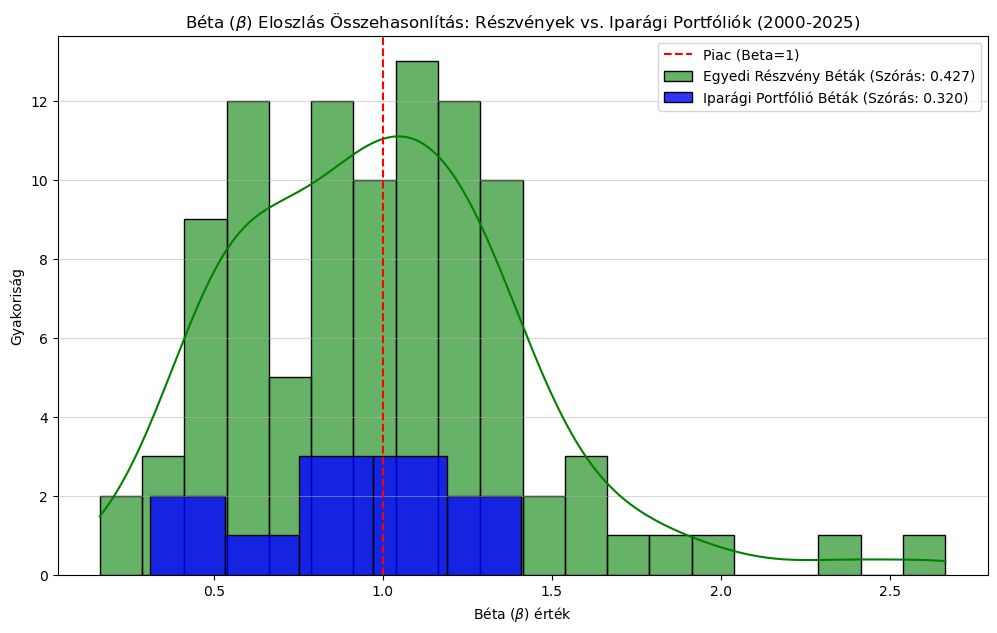

In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------------------------
# IPARÁGI LEKÉPEZÉS (TICKER -> SZEKTOR)
# --------------------------------------------------------------------------
SECTOR_MAPPING = {
    # 1. INFORMATION TECHNOLOGY (IT)
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology', 
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CSCO': 'Information Technology', 
    'CRM': 'Information Technology', 'INTC': 'Information Technology', 'INTU': 'Information Technology', 
    'MSFT': 'Information Technology', 'NOW': 'Information Technology', 'NVDA': 'Information Technology', 
    'ORCL': 'Information Technology', 'PYPL': 'Information Technology', 'QCOM': 'Information Technology', 
    'TXN': 'Information Technology', 'PLTR': 'Information Technology',

    # 2. HEALTH CARE (Egészségügy)
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care', 
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',

    # 3. FINANCIALS (Pénzügy)
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials', 
    'MS': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials', 'V': 'Financials', 
    'WFC': 'Financials',

    # 4. CONSUMER DISCRETIONARY (Fogyasztói ciklikus)
    'AMZN': 'Consumer Discretionary', 'BKNG': 'Consumer Discretionary', 'DIS': 'Consumer Discretionary', 
    'FDX': 'Consumer Discretionary', 'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 
    'NKE': 'Consumer Discretionary', 'NFLX': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 
    'TGT': 'Consumer Discretionary', 'TSLA': 'Consumer Discretionary', 'UBER': 'Consumer Discretionary',

    # 5. CONSUMER STAPLES (Fogyasztói defenzív)
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples', 'MCD': 'Consumer Staples', 
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples', 'PG': 'Consumer Staples', 
    'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',

    # 6. INDUSTRIALS (Ipar)
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',

    # 7. COMMUNICATION SERVICES (Kommunikációs szolgáltatások)
    'CMCSA': 'Comm. Services', 'GOOG': 'Comm. Services', 'GOOGL': 'Comm. Services', 
    'META': 'Comm. Services', 'T': 'Comm. Services', 'TMUS': 'Comm. Services', 'VZ': 'Comm. Services', 

    # 8. ENERGY (Energia)
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',

    # 9. UTILITIES (Közművek)
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities',

    # 10. REAL ESTATE (Ingatlan)
    'AMT': 'Real Estate', 'SPG': 'Real Estate',

    # 11. MATERIALS (Alapanyagok)
    'LIN': 'Materials',
}

# --- Preprocessing Function (Corrected Date Column Handling) ---
def preprocess_data(df, date_col, rate_col=None):
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    if rate_col:
        data_col_name = df.columns[0]
        df = df.rename(columns={data_col_name: rate_col})
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace('%', '', regex=False).str.replace(',', '.', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# --- Load and Preprocess Data ---
stock_returns_raw = pd.read_csv('monthly_stock_returns.csv')
market_returns_raw = pd.read_csv('monthly_market_returns.csv')
risk_free_rate_raw = pd.read_csv('monthly_risk_free_rate.csv')

# Correct date column handling based on inspection
stock_returns = preprocess_data(stock_returns_raw, date_col='Date')
market_returns = preprocess_data(market_returns_raw, date_col='Date', rate_col='MKT')
risk_free_rate = preprocess_data(risk_free_rate_raw, date_col='DATE', rate_col='RF')

# Merge data (Full Data)
full_data = stock_returns.merge(market_returns, left_index=True, right_index=True)
full_data = full_data.merge(risk_free_rate, left_index=True, right_index=True)

# Calculate Market Risk Premium (MKT_RP = MKT - RF)
full_data['MKT_RP'] = full_data['MKT'] - full_data['RF']
full_data = full_data.dropna(subset=['MKT_RP', 'RF'])

# --- Define the First Pass Regression Function ---
def excel_first_pass(data_df, start_date, end_date, rp_prefix='RP_'):
    
    df_filtered = data_df.loc[start_date:end_date]
    rp_cols = [col for col in df_filtered.columns if col.startswith(rp_prefix)]
    results_list = []
    
    X = df_filtered['MKT_RP']
    X = sm.add_constant(X)
    
    for rp_col in rp_cols:
        Y = df_filtered[rp_col].dropna()
        common_index = Y.index.intersection(X.index)
        Y_clean = Y.loc[common_index]
        X_clean = X.loc[common_index]
        
        if len(Y_clean) < 12:
            continue
            
        model = sm.OLS(Y_clean, X_clean)
        try:
            results = model.fit()
            beta = results.params['MKT_RP']
            results_list.append({
                'ticker': rp_col.replace(rp_prefix, ''),
                'beta': beta
            })
        except (np.linalg.LinAlgError, ValueError):
            continue
    return pd.DataFrame(results_list)

# --------------------------------------------------------------------------
# 1. RÉSZ: EGYEDI RÉSZVÉNY BÉTÁK
# --------------------------------------------------------------------------

# Calculate Stock Excess Returns (RP_i = R_i - RF) for individual stocks
stock_cols = [col for col in stock_returns.columns if col in SECTOR_MAPPING.keys()] # Only take stocks with sector mapping
stock_excess_returns_df = pd.DataFrame(index=full_data.index)

for col in stock_cols:
    stock_excess_returns_df[f'RP_{col}'] = full_data[col] - full_data['RF']

stock_excess_returns_df['MKT_RP'] = full_data['MKT_RP']
stock_excess_returns_df = stock_excess_returns_df.dropna(subset=['MKT_RP'])

# Run regression for individual stocks
stock_beta_results = excel_first_pass(stock_excess_returns_df, '2000-01-01', '2025-11-01')
stock_betas = stock_beta_results['beta'].dropna()
stock_std = stock_betas.std()
print(f"Egyedi részvény béták szórása: {stock_std:.6f}")

# --------------------------------------------------------------------------
# 2. RÉSZ: IPARÁGI PORTFÓLIÓ BÉTÁK
# --------------------------------------------------------------------------

# Form Portfolio Returns (R_p)
portfolio_returns_raw = stock_returns[stock_cols] # Filter to only mapped stocks

# Map sectors to columns
sector_series = pd.Series(SECTOR_MAPPING)
portfolio_returns_raw = portfolio_returns_raw[sector_series.index] # Filter to only mapped stocks

# Calculate Equal-Weighted Portfolio Returns (R_p_sector): mean of raw returns in each sector
portfolio_returns = portfolio_returns_raw.apply(lambda x: pd.to_numeric(x, errors='coerce')).groupby(sector_series, axis=1).mean()

# Merge with MKT_RP and RF
portfolio_data = portfolio_returns.merge(risk_free_rate, left_index=True, right_index=True)
portfolio_data = portfolio_data.merge(market_returns, left_index=True, right_index=True)

# Calculate Portfolio Excess Returns (RP_p = R_p - R_f)
portfolio_excess_returns_df = pd.DataFrame(index=portfolio_data.index)
for sector in portfolio_returns.columns:
    portfolio_excess_returns_df[f'RP_{sector}'] = portfolio_data[sector] - portfolio_data['RF']

# Use the MKT_RP calculated on full data (ensuring index alignment)
common_index = portfolio_excess_returns_df.index.intersection(full_data.index)
portfolio_excess_returns_df = portfolio_excess_returns_df.loc[common_index]
portfolio_excess_returns_df['MKT_RP'] = full_data['MKT_RP'].loc[common_index]

# Run regression for portfolio returns
portfolio_beta_results = excel_first_pass(portfolio_excess_returns_df, '2000-01-01', '2025-11-01', rp_prefix='RP_')
portfolio_betas = portfolio_beta_results['beta'].dropna()
portfolio_std = portfolio_betas.std()
print(f"Portfólió béták szórása: {portfolio_std:.6f}")

# --------------------------------------------------------------------------
# 3. RÉSZ: ÁBRA (ÖSSZEHASONLÍTÁS)
# --------------------------------------------------------------------------
plt.figure(figsize=(12, 7))

# Hisztogram: Egyedi Részvény Béták
sns.histplot(stock_betas, bins=20, kde=True, color='green', alpha=0.6, label=f'Egyedi Részvény Béták (Szórás: {stock_std:.3f})')

# Hisztogram: Iparági Portfólió Béták
sns.histplot(portfolio_betas, bins=5, kde=False, color='blue', alpha=0.8, label=f'Iparági Portfólió Béták (Szórás: {portfolio_std:.3f})')

# Piac vonal (fixed LaTeX error)
plt.axvline(x=1, color='red', linestyle='--', label='Piac (Beta=1)')

plt.title(r'Béta ($\beta$) Eloszlás Összehasonlítás: Részvények vs. Iparági Portfóliók (2000-2025)')
plt.xlabel(r'Béta ($\beta$) érték')
plt.ylabel('Gyakoriság')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.savefig('beta_eloszlas_osszehasonlitas.png')
print("\nA hisztogram összehasonlítás elkészült és 'beta_eloszlas_osszehasonlitas.png' néven elmentve.")

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import t as tdist

# =============================================================================
# ADAT ELŐKÉSZÍTÉS ÉS SEGÉDFÜGGVÉNYEK (REQUIRED FROM NOTEBOOK)
# =============================================================================

# --- Load and Prepare Monthly Data (as in Notebook Cell 2) ---
s = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
m = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
r = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

# Dátumok igazítása
s.index = s.index.to_period('M').to_timestamp()
m.index = m.index.to_period('M').to_timestamp()
r.index = r.index.to_period('M').to_timestamp()

rf_col = r.columns[0]
r = r.rename(columns={rf_col: 'Risk_Free_Rate'})
rf_lag = r['Risk_Free_Rate'].shift(1) 

df = s.join(m, how='inner').join(rf_lag, how='inner')
market_col = [c for c in df.columns if c not in s.columns and c != 'Risk_Free_Rate'][0]
df = df.rename(columns={market_col: 'SP100_rp'})

cols_to_adjust = [c for c in df.columns if c != 'Risk_Free_Rate']
RP = df[cols_to_adjust].sub(df['Risk_Free_Rate'], axis=0)
RP = RP.iloc[1:]
RP_aligned = RP.dropna(axis=1, how='any')


# --- First Pass Function (as in Notebook Cell 3) ---
def excel_first_pass(RP, start, end):
    RP_period = RP_aligned.loc[start:end]
    RM = RP_period['SP100_rp']
    rows = []
    
    for ticker in RP_period.columns:
        if ticker == 'SP100_rp': continue
        
        stock_data = pd.concat([RP_period[ticker], RM], axis=1).dropna()
        if len(stock_data) < 12: continue 
        
        Ri = stock_data[ticker]
        Rm_clean = stock_data['SP100_rp']
        
        cov = np.cov(Ri, Rm_clean)[0, 1]
        var = np.var(Rm_clean, ddof=1)
        beta = cov / var
        
        # Idioszinkratikus variancia (Sigma^2)
        sigma2 = np.var(Ri - beta * Rm_clean, ddof=1)
        
        riskprem_mean = Ri.mean()
        
        rows.append([ticker, beta, sigma2, riskprem_mean])
        
    return pd.DataFrame(rows, columns=['Ticker', 'beta', 'sigma2', 'riskprem_mean'])


# --- SECTOR MAPPING (as in Notebook Cell 15) ---
SECTOR_MAPPING = {
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology', 
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CSCO': 'Information Technology', 
    'CRM': 'Information Technology', 'INTC': 'Information Technology', 'INTU': 'Information Technology', 
    'MSFT': 'Information Technology', 'NOW': 'Information Technology', 'NVDA': 'Information Technology', 
    'ORCL': 'Information Technology', 'PYPL': 'Information Technology', 'QCOM': 'Information Technology', 
    'TXN': 'Information Technology', 'PLTR': 'Information Technology',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care', 
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials', 
    'MS': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials', 'V': 'Financials', 
    'WFC': 'Financials',
    'AMZN': 'Consumer Discretionary', 'BKNG': 'Consumer Discretionary', 'DIS': 'Consumer Discretionary', 
    'FDX': 'Consumer Discretionary', 'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 
    'NKE': 'Consumer Discretionary', 'NFLX': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 
    'TGT': 'Consumer Discretionary', 'TSLA': 'Consumer Discretionary', 'UBER': 'Consumer Discretionary',
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples', 'MCD': 'Consumer Staples', 
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples', 'PG': 'Consumer Staples', 
    'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'CMCSA': 'Comm. Services', 'GOOG': 'Comm. Services', 'GOOGL': 'Comm. Services', 
    'META': 'Comm. Services', 'T': 'Comm. Services', 'TMUS': 'Comm. Services', 'VZ': 'Comm. Services', 
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities',
    'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'LIN': 'Materials',
}


# --- RUN SECOND PASS REGRESSION (MODEL 2) AND EXTRACT GAMMAS ---
def run_capm_model2_test(sec_pass_data, market_rp_mean, asset_type):
    n_obs = len(sec_pass_data)
    df_p = n_obs - 3 # degree of freedom for Model 2
    alpha_level = 0.05
    
    # Second Pass (Model 2: Beta + Sigma^2)
    # y = riskprem_mean, X = [const, beta, sigma2]
    X2 = sm.add_constant(sec_pass_data[['beta', 'sigma2']])
    model2 = sm.OLS(sec_pass_data['riskprem_mean'], X2).fit()
    
    # Eredmények
    g0 = model2.params['const']
    g1 = model2.params['beta']
    g2 = model2.params['sigma2']
    p_g0 = model2.pvalues['const']
    p_g2 = model2.pvalues['sigma2']
    
    # Gamma 1 p-value (vs Market RP: H0: g1 = Market RP)
    se_g1 = model2.bse['beta']
    t_g1 = (g1 - market_rp_mean) / se_g1
    p_g1_vs_mrp = 2 * (1 - tdist.cdf(abs(t_g1), df_p))

    # Döntések megállapítása a táblázathoz
    dec_g0 = "Megfelel (CAPM)" if p_g0 >= alpha_level else "Nem felel meg (Alfa)"
    dec_g1 = "Megfelel (SML)" if p_g1_vs_mrp >= alpha_level else "Nem felel meg (SML)"
    dec_g2 = "Megfelel (CAPM)" if p_g2 >= alpha_level else "Nem felel meg (Sigma^2)"
    
    return {
        'Típus': asset_type,
        'N (Assets)': n_obs,
        'Piaci RP (H0)': market_rp_mean,
        'Gamma 0': g0, 
        'p(g0=0)': p_g0, 
        'Gamma 1': g1, 
        'p(g1=MRP)': p_g1_vs_mrp, 
        'Gamma 2': g2, 
        'p(g2=0)': p_g2,
        'Döntés (γ0)': dec_g0,
        'Döntés (γ1)': dec_g1,
        'Döntés (γ2)': dec_g2
    }


# =============================================================================
# FŐ ÖSSZEHASONLÍTÓ LOGIKA
# =============================================================================
results_comparison = []
start_date = '2000-01-01'
end_date = '2025-11-01'
market_rp_mean = RP_aligned['SP100_rp'].loc[start_date:end_date].mean()

# --------------------------
# A) EGYEDI RÉSZVÉNY TESZT
# --------------------------
individual_first_pass = excel_first_pass(RP_aligned, start_date, end_date)
individual_sec_pass_data = individual_first_pass.set_index('Ticker')
individual_results = run_capm_model2_test(individual_sec_pass_data, market_rp_mean, 'Egyedi részvények')
results_comparison.append(individual_results)


# --------------------------
# B) IPARÁGI PORTFÓLIÓ TESZT
# --------------------------
# 1. Kialakítás
stock_ret_raw = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
rf_rate_raw = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

stock_ret_raw.index = stock_ret_raw.index.to_period('M').to_timestamp()
rf_rate_raw.index = rf_rate_raw.index.to_period('M').to_timestamp()

stock_ret_clean = stock_ret_raw.loc[start_date:end_date].dropna(axis=0, how='all').dropna(axis=1, how='any')
data_port = pd.concat([stock_ret_clean, rf_rate_raw], axis=1).dropna()
rf_col_port = rf_rate_raw.columns[0]

stock_excess_ret = data_port[stock_ret_clean.columns].sub(data_port[rf_col_port], axis=0)

sectors_map = stock_excess_ret.columns.map(SECTOR_MAPPING)
portfolio_excess_returns = stock_excess_ret.groupby(sectors_map, axis=1).mean()


# 2. First Pass (Portfóliókra)
market_ret_raw = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
market_ret_raw.index = market_ret_raw.index.to_period('M').to_timestamp()
data_full = pd.concat([portfolio_excess_returns, market_ret_raw, rf_rate_raw], axis=1).dropna()
market_col_full = market_ret_raw.columns[0]
data_full['Market_RP'] = data_full[market_col_full] - data_full[rf_col_port]

port_betas = []
port_avg_excess_ret = []
port_var_residuals = []
X_port = sm.add_constant(data_full['Market_RP'])

for sector in portfolio_excess_returns.columns:
    y_port = data_full[sector]
    model_port = sm.OLS(y_port, X_port).fit()
    port_betas.append(model_port.params['Market_RP'])
    port_avg_excess_ret.append(y_port.mean())
    port_var_residuals.append(model_port.mse_resid)
    
portfolio_sec_pass_data = pd.DataFrame({
    'riskprem_mean': port_avg_excess_ret,
    'beta': port_betas,
    'sigma2': port_var_residuals
}, index=portfolio_excess_returns.columns)

# 3. Second Pass Test
portfolio_results = run_capm_model2_test(portfolio_sec_pass_data, market_rp_mean, 'Iparági portfóliók')
results_comparison.append(portfolio_results)


# --------------------------
# C) TÁBLÁZAT LÉTREHOZÁSA ÉS KIÍRÁSA
# --------------------------
df_comparison = pd.DataFrame(results_comparison)

cols_order = [
    'Típus', 'N (Assets)', 'Piaci RP (H0)', 
    'Gamma 0', 'p(g0=0)', 'Döntés (γ0)',
    'Gamma 1', 'p(g1=MRP)', 'Döntés (γ1)',
    'Gamma 2', 'p(g2=0)', 'Döntés (γ2)'
]

pd.options.display.float_format = '{:.6f}'.format

print("\n\n=== CAPM ÖSSZEHASONLÍTÓ TÁBLÁZAT (HAVI ADATOK, MODEL 2) ===")
print("Eredmények összehasonlítása az egyedi részvények és az iparági portfóliók között.")
print("-------------------------------------------------------------------------------------------------")
print(df_comparison[cols_order].to_string(index=False))
print("-------------------------------------------------------------------------------------------------")
print("Jelmagyarázat: A CAPM teljesüléséhez az összes döntésnek 'Megfelel (CAPM/SML)' kell lennie.")



=== CAPM ÖSSZEHASONLÍTÓ TÁBLÁZAT (HAVI ADATOK, MODEL 2) ===
Eredmények összehasonlítása az egyedi részvények és az iparági portfóliók között.
-------------------------------------------------------------------------------------------------
             Típus  N (Assets)  Piaci RP (H0)  Gamma 0  p(g0=0)          Döntés (γ0)  Gamma 1  p(g1=MRP)    Döntés (γ1)  Gamma 2  p(g2=0)             Döntés (γ2)
 Egyedi részvények          80       0.004368 0.005125 0.000279 Nem felel meg (Alfa) 0.002666   0.291609 Megfelel (SML) 0.417832 0.000727 Nem felel meg (Sigma^2)
Iparági portfóliók          11       0.004368 0.005194 0.059751      Megfelel (CAPM) 0.004619   0.918518 Megfelel (SML) 0.339140 0.580554         Megfelel (CAPM)
-------------------------------------------------------------------------------------------------
Jelmagyarázat: A CAPM teljesüléséhez az összes döntésnek 'Megfelel (CAPM/SML)' kell lennie.


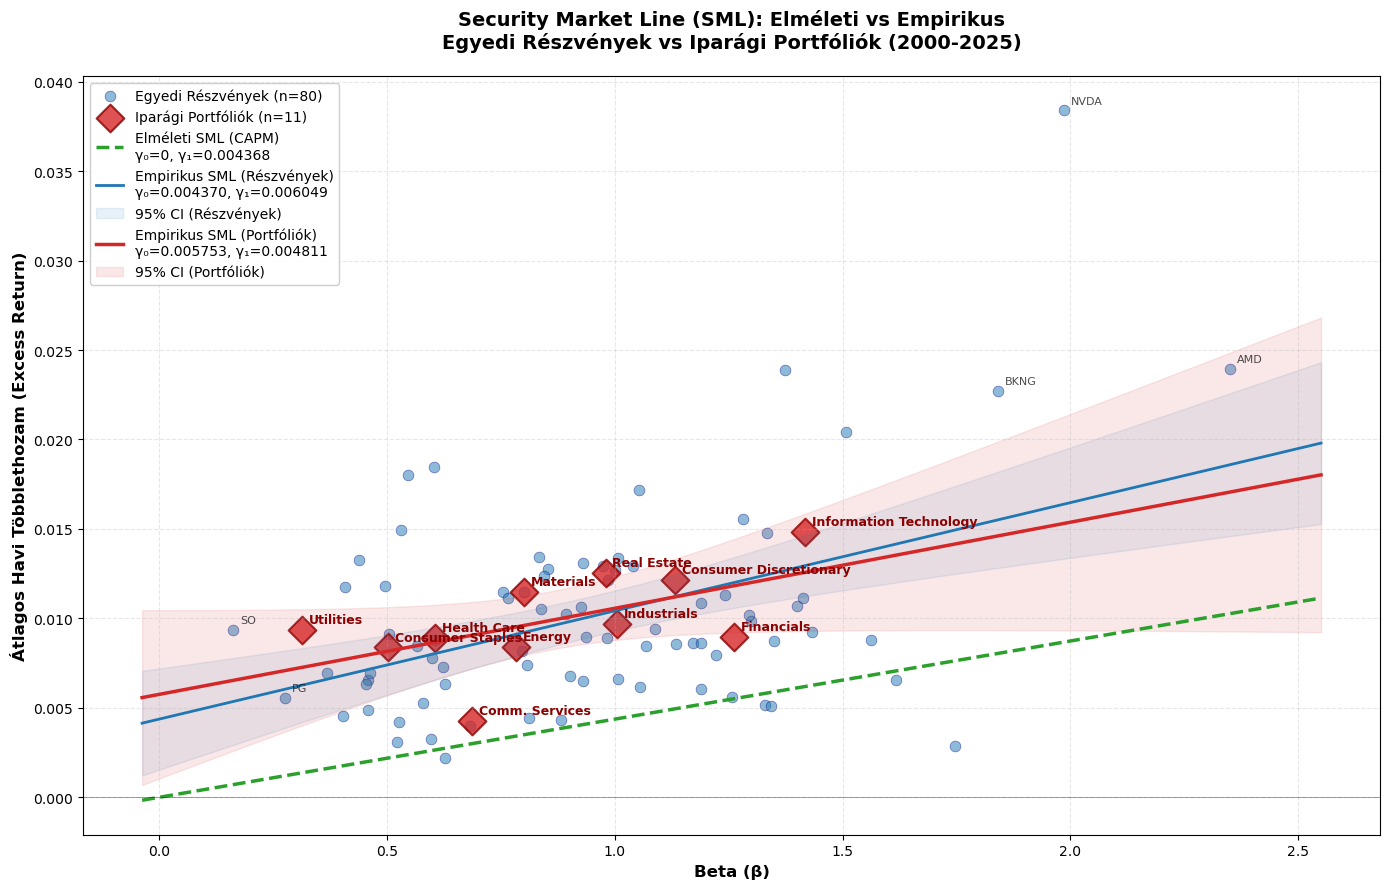


SML KOMBINÁLT ÁBRA - ÖSSZEFOGLALÓ

Elméleti SML (CAPM):
  γ₀ (alpha) = 0 (feltételezés)
  γ₁ (Market RP) = 0.004368

Empiikus SML - RÉSZVÉNYEK (Model 1: Csak Beta):
  γ₀ (alpha) = 0.004370 (p-érték: 0.0029)
  γ₁ (Market RP) = 0.006049 (p-érték: 0.0000)
  R² = 0.1992

Empiikus SML - PORTFÓLIÓK (Model 1: Csak Beta):
  γ₀ (alpha) = 0.005753 (p-érték: 0.0219)
  γ₁ (Market RP) = 0.004811 (p-érték: 0.0624)
  R² = 0.3343

✓ Ábra mentve: sml_combined_analysis.png


In [106]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ============================================================================
# ADAT ELŐKÉSZÍTÉS (az előző cellákból)
# ============================================================================

# Load and Prepare Monthly Data
s = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
m = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
r = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

# Dátumok igazítása
s.index = s.index.to_period('M').to_timestamp()
m.index = m.index.to_period('M').to_timestamp()
r.index = r.index.to_period('M').to_timestamp()

rf_col = r.columns[0]
r = r.rename(columns={rf_col: 'Risk_Free_Rate'})
rf_lag = r['Risk_Free_Rate'].shift(1) 

df = s.join(m, how='inner').join(rf_lag, how='inner')
market_col = [c for c in df.columns if c not in s.columns and c != 'Risk_Free_Rate'][0]
df = df.rename(columns={market_col: 'SP100_rp'})

cols_to_adjust = [c for c in df.columns if c != 'Risk_Free_Rate']
RP = df[cols_to_adjust].sub(df['Risk_Free_Rate'], axis=0)
RP = RP.iloc[1:]
RP_aligned = RP.dropna(axis=1, how='any')

start_date = '2000-01-01'
end_date = '2025-11-01'
market_rp_mean = RP_aligned['SP100_rp'].loc[start_date:end_date].mean()

# ============================================================================
# SECTOR MAPPING
# ============================================================================

SECTOR_MAPPING = {
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology', 
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CSCO': 'Information Technology', 
    'CRM': 'Information Technology', 'INTC': 'Information Technology', 'INTU': 'Information Technology', 
    'MSFT': 'Information Technology', 'NOW': 'Information Technology', 'NVDA': 'Information Technology', 
    'ORCL': 'Information Technology', 'PYPL': 'Information Technology', 'QCOM': 'Information Technology', 
    'TXN': 'Information Technology', 'PLTR': 'Information Technology',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care', 
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials', 
    'MS': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials', 'V': 'Financials', 
    'WFC': 'Financials',
    'AMZN': 'Consumer Discretionary', 'BKNG': 'Consumer Discretionary', 'DIS': 'Consumer Discretionary', 
    'FDX': 'Consumer Discretionary', 'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 
    'NKE': 'Consumer Discretionary', 'NFLX': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 
    'TGT': 'Consumer Discretionary', 'TSLA': 'Consumer Discretionary', 'UBER': 'Consumer Discretionary',
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples', 'MCD': 'Consumer Staples', 
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples', 'PG': 'Consumer Staples', 
    'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'CMCSA': 'Comm. Services', 'GOOG': 'Comm. Services', 'GOOGL': 'Comm. Services', 
    'META': 'Comm. Services', 'T': 'Comm. Services', 'TMUS': 'Comm. Services', 'VZ': 'Comm. Services', 
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities',
    'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'LIN': 'Materials',
}

# ============================================================================
# FIRST PASS - EGYEDI RÉSZVÉNYEK
# ============================================================================

def excel_first_pass(RP, start, end):
    """First-pass: β és σ² becslése minden részvényre"""
    RP_period = RP_aligned.loc[start:end]
    RM = RP_period['SP100_rp']
    rows = []
    
    for ticker in RP_period.columns:
        if ticker == 'SP100_rp': 
            continue
        
        stock_data = pd.concat([RP_period[ticker], RM], axis=1).dropna()
        if len(stock_data) < 12: 
            continue 
        
        Ri = stock_data[ticker]
        Rm_clean = stock_data['SP100_rp']
        
        cov = np.cov(Ri, Rm_clean)[0, 1]
        var = np.var(Rm_clean, ddof=1)
        beta = cov / var
        sigma2 = np.var(Ri - beta * Rm_clean, ddof=1)
        riskprem_mean = Ri.mean()
        
        rows.append([ticker, beta, sigma2, riskprem_mean])
        
    return pd.DataFrame(rows, columns=['Ticker', 'beta', 'sigma2', 'riskprem_mean'])


# Egyedi részvények
individual_fp = excel_first_pass(RP_aligned, start_date, end_date)
individual_sec_pass = individual_fp.set_index('Ticker')

# ============================================================================
# FIRST PASS - IPARÁGI PORTFÓLIÓK
# ============================================================================

stock_ret_raw = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
rf_rate_raw = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)
market_ret_raw = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)

# Date alignment
stock_ret_raw.index = stock_ret_raw.index.to_period('M').to_timestamp()
rf_rate_raw.index = rf_rate_raw.index.to_period('M').to_timestamp()
market_ret_raw.index = market_ret_raw.index.to_period('M').to_timestamp()

# Filter időszak
stock_ret_clean = stock_ret_raw.loc[start_date:end_date].dropna(axis=0, how='all').dropna(axis=1, how='any')
data_port = pd.concat([stock_ret_clean, rf_rate_raw], axis=1).dropna()
rf_col_port = rf_rate_raw.columns[0]

# Excess returns
stock_excess_ret = data_port[stock_ret_clean.columns].sub(data_port[rf_col_port], axis=0)

# Portfóliók (Equal-weighted)
sectors_map = stock_excess_ret.columns.map(SECTOR_MAPPING)
portfolio_excess_ret = stock_excess_ret.groupby(sectors_map, axis=1).mean()

# First pass portfóliókon
data_full = pd.concat([portfolio_excess_ret, market_ret_raw, rf_rate_raw], axis=1).dropna()
market_col_full = market_ret_raw.columns[0]
data_full['Market_RP'] = data_full[market_col_full] - data_full[rf_col_port]

# Béták és sigmaak
port_betas = []
port_ret_avg = []
port_sigma2 = []
X_port = sm.add_constant(data_full['Market_RP'])

for sector in portfolio_excess_ret.columns:
    y = data_full[sector]
    model_fp = sm.OLS(y, X_port).fit()
    port_betas.append(model_fp.params['Market_RP'])
    port_ret_avg.append(y.mean())
    port_sigma2.append(model_fp.mse_resid)

port_sec_pass = pd.DataFrame({
    'riskprem_mean': port_ret_avg,
    'beta': port_betas,
    'sigma2': port_sigma2
}, index=portfolio_excess_ret.columns)

# ============================================================================
# SECOND PASS REGRESSZIÓK - SML VONALAK
# ============================================================================
# JAVÍTOTT: CSAK BETA-VAL (nem sigma2)

# 1. Egyedi részvények - Regresszió (CSAK BETA)
X_stocks = sm.add_constant(individual_sec_pass['beta'])
model_stocks = sm.OLS(individual_sec_pass['riskprem_mean'], X_stocks).fit()
gamma0_stocks = model_stocks.params['const']
gamma1_stocks = model_stocks.params['beta']

# 2. Iparági portfóliók - Regresszió (CSAK BETA)
X_port_pass = sm.add_constant(port_sec_pass['beta'])
model_port = sm.OLS(port_sec_pass['riskprem_mean'], X_port_pass).fit()
gamma0_port = model_port.params['const']
gamma1_port = model_port.params['beta']

# ============================================================================
# SML KOMBINÁLT ÁBRA
# ============================================================================

# Adatok
betas_stocks = individual_sec_pass['beta']
avg_returns_stocks = individual_sec_pass['riskprem_mean']

betas_port = port_sec_pass['beta']
avg_returns_port = port_sec_pass['riskprem_mean']

# Beta rács a vonalakhoz
beta_min = min(betas_stocks.min(), betas_port.min())
beta_max = max(betas_stocks.max(), betas_port.max())
beta_grid = np.linspace(beta_min - 0.2, beta_max + 0.2, 100)

# 1. Elméleti SML: y = 0 + Market_RP * beta
theory_sml = market_rp_mean * beta_grid

# 2. Empirikus SML (Részvények): y = gamma0_stocks + gamma1_stocks * beta
X_pred_stocks = sm.add_constant(beta_grid)
empirical_sml_stocks = model_stocks.predict(X_pred_stocks)
pred_obj_stocks = model_stocks.get_prediction(X_pred_stocks)
ci_stocks = pred_obj_stocks.conf_int()
lower_stocks, upper_stocks = ci_stocks[:, 0], ci_stocks[:, 1]

# 3. Empirikus SML (Portfóliók): y = gamma0_port + gamma1_port * beta
X_pred_port = sm.add_constant(beta_grid)
empirical_sml_port = model_port.predict(X_pred_port)
pred_obj_port = model_port.get_prediction(X_pred_port)
ci_port = pred_obj_port.conf_int()
lower_port, upper_port = ci_port[:, 0], ci_port[:, 1]

# ============================================================================
# ÁBRA MEGJELENÍTÉS
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 9))

# 1. EGYEDI RÉSZVÉNYEK (Kék pontok)
ax.scatter(betas_stocks, avg_returns_stocks, 
          color='#1f77b4', alpha=0.5, s=60, 
          label=f'Egyedi Részvények (n={len(betas_stocks)})', 
          edgecolors='navy', linewidth=0.5)

# 2. IPARÁGI PORTFÓLIÓK (Piros diamantok, nagyobb méret)
ax.scatter(betas_port, avg_returns_port, 
          color='#d62728', alpha=0.8, s=200, marker='D',
          label=f'Iparági Portfóliók (n={len(betas_port)})', 
          edgecolors='darkred', linewidth=1.5)

# 3. ELMÉLETI SML (Zöld szaggatott vonal)
ax.plot(beta_grid, theory_sml, 
       color='#2ca02c', linestyle='--', linewidth=2.5, 
       label=f'Elméleti SML (CAPM)\nγ₀=0, γ₁={market_rp_mean:.6f}')

# 4. EMPIRIKUS SML - RÉSZVÉNYEK (Kék folytonos vonal)
ax.plot(beta_grid, empirical_sml_stocks, 
       color='#1f77b4', linestyle='-', linewidth=2, 
       label=f'Empirikus SML (Részvények)\nγ₀={gamma0_stocks:.6f}, γ₁={gamma1_stocks:.6f}')
ax.fill_between(beta_grid, lower_stocks, upper_stocks, 
               color='#1f77b4', alpha=0.1, label='95% CI (Részvények)')

# 5. EMPIRIKUS SML - PORTFÓLIÓK (Piros folytonos vonal)
ax.plot(beta_grid, empirical_sml_port, 
       color='#d62728', linestyle='-', linewidth=2.5, 
       label=f'Empirikus SML (Portfóliók)\nγ₀={gamma0_port:.6f}, γ₁={gamma1_port:.6f}')
ax.fill_between(beta_grid, lower_port, upper_port, 
               color='#d62728', alpha=0.1, label='95% CI (Portfóliók)')

# Feliratok: Szélsőséges értékek (részvények)
for ticker in betas_stocks.index:
    if (betas_stocks[ticker] > 1.8 or betas_stocks[ticker] < 0.3 or 
        avg_returns_stocks[ticker] > 0.025 or avg_returns_stocks[ticker] < -0.005):
        ax.annotate(ticker, 
                   xy=(betas_stocks[ticker], avg_returns_stocks[ticker]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, alpha=0.7)

# Feliratok: Szektorok (portfóliók)
for sector in betas_port.index:
    ax.annotate(sector, 
               xy=(betas_port[sector], avg_returns_port[sector]),
               xytext=(5, 5), textcoords='offset points',
               fontsize=9, fontweight='bold', color='darkred')

# Formázás
ax.set_xlabel('Beta (β)', fontsize=12, fontweight='bold')
ax.set_ylabel('Átlagos Havi Többlethozam (Excess Return)', fontsize=12, fontweight='bold')
ax.set_title('Security Market Line (SML): Elméleti vs Empirikus\nEgyedi Részvények vs Iparági Portfóliók (2000-2025)', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='upper left', framealpha=0.95)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig('sml_combined_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*100)
print("SML KOMBINÁLT ÁBRA - ÖSSZEFOGLALÓ")
print("="*100)
print(f"\nElméleti SML (CAPM):")
print(f"  γ₀ (alpha) = 0 (feltételezés)")
print(f"  γ₁ (Market RP) = {market_rp_mean:.6f}")
print(f"\nEmpiikus SML - RÉSZVÉNYEK (Model 1: Csak Beta):")
print(f"  γ₀ (alpha) = {gamma0_stocks:.6f} (p-érték: {model_stocks.pvalues['const']:.4f})")
print(f"  γ₁ (Market RP) = {gamma1_stocks:.6f} (p-érték: {model_stocks.pvalues['beta']:.4f})")
print(f"  R² = {model_stocks.rsquared:.4f}")
print(f"\nEmpiikus SML - PORTFÓLIÓK (Model 1: Csak Beta):")
print(f"  γ₀ (alpha) = {gamma0_port:.6f} (p-érték: {model_port.pvalues['const']:.4f})")
print(f"  γ₁ (Market RP) = {gamma1_port:.6f} (p-érték: {model_port.pvalues['beta']:.4f})")
print(f"  R² = {model_port.rsquared:.4f}")
print("\n✓ Ábra mentve: sml_combined_analysis.png")
print("="*100)

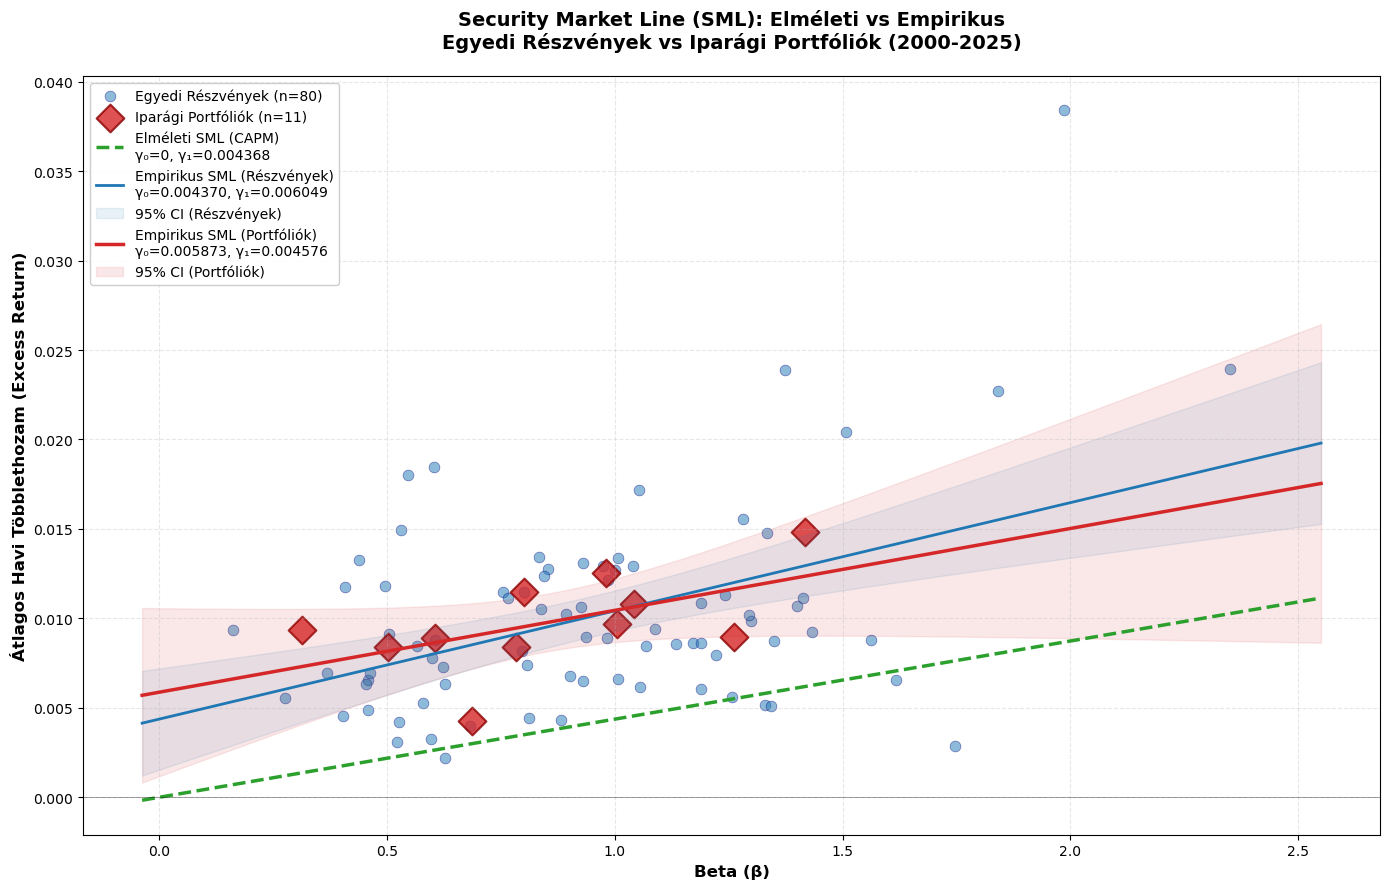


SML KOMBINÁLT ÁBRA - ÖSSZEFOGLALÓ

Elméleti SML (CAPM):
  γ₀ (alpha) = 0 (feltételezés)
  γ₁ (Market RP) = 0.004368

Empiikus SML - RÉSZVÉNYEK (Model 1: Csak Beta):
  γ₀ (alpha) = 0.004370 (p-érték: 0.0029)
  γ₁ (Market RP) = 0.006049 (p-érték: 0.0000)
  R² = 0.1992

Empiikus SML - PORTFÓLIÓK (Model 1: Csak Beta):
  γ₀ (alpha) = 0.005873 (p-érték: 0.0197)
  γ₁ (Market RP) = 0.004576 (p-érték: 0.0760)
  R² = 0.3087

✓ Ábra mentve: sml_combined_analysis.png


In [108]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ============================================================================
# ADAT ELŐKÉSZÍTÉS (az előző cellákból)
# ============================================================================

# Load and Prepare Monthly Data
s = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
m = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)
r = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)

# Dátumok igazítása
s.index = s.index.to_period('M').to_timestamp()
m.index = m.index.to_period('M').to_timestamp()
r.index = r.index.to_period('M').to_timestamp()

rf_col = r.columns[0]
r = r.rename(columns={rf_col: 'Risk_Free_Rate'})
rf_lag = r['Risk_Free_Rate'].shift(1) 

df = s.join(m, how='inner').join(rf_lag, how='inner')
market_col = [c for c in df.columns if c not in s.columns and c != 'Risk_Free_Rate'][0]
df = df.rename(columns={market_col: 'SP100_rp'})

cols_to_adjust = [c for c in df.columns if c != 'Risk_Free_Rate']
RP = df[cols_to_adjust].sub(df['Risk_Free_Rate'], axis=0)
RP = RP.iloc[1:]
RP_aligned = RP.dropna(axis=1, how='any')

start_date = '2000-01-01'
end_date = '2025-11-01'
market_rp_mean = RP_aligned['SP100_rp'].loc[start_date:end_date].mean()

# ============================================================================
# SECTOR MAPPING
# ============================================================================

SECTOR_MAPPING = {
    'AAPL': 'Information Technology', 'ACN': 'Information Technology', 'ADBE': 'Information Technology', 
    'AMD': 'Information Technology', 'AVGO': 'Information Technology', 'CSCO': 'Information Technology', 
    'CRM': 'Information Technology', 'INTC': 'Information Technology', 'INTU': 'Information Technology', 
    'MSFT': 'Information Technology', 'NOW': 'Information Technology', 'NVDA': 'Information Technology', 
    'ORCL': 'Information Technology', 'PYPL': 'Information Technology', 'QCOM': 'Information Technology', 
    'TXN': 'Information Technology', 'PLTR': 'Information Technology',
    'ABBV': 'Health Care', 'ABT': 'Health Care', 'AMGN': 'Health Care', 'BMY': 'Health Care', 
    'CVS': 'Health Care', 'DHR': 'Health Care', 'GILD': 'Health Care', 'ISRG': 'Health Care', 
    'JNJ': 'Health Care', 'LLY': 'Health Care', 'MDT': 'Health Care', 'MRK': 'Health Care', 
    'PFE': 'Health Care', 'TMO': 'Health Care', 'UNH': 'Health Care',
    'AIG': 'Financials', 'AXP': 'Financials', 'BAC': 'Financials', 'BK': 'Financials', 
    'BLK': 'Financials', 'BRK-B': 'Financials', 'C': 'Financials', 'COF': 'Financials', 
    'GS': 'Financials', 'JPM': 'Financials', 'MA': 'Financials', 'MET': 'Financials', 
    'MS': 'Financials', 'SCHW': 'Financials', 'USB': 'Financials', 'V': 'Financials', 
    'WFC': 'Financials',
    'AMZN': 'Consumer Discretionary', 'BKKING': 'Consumer Discretionary', 'DIS': 'Consumer Discretionary', 
    'FDX': 'Consumer Discretionary', 'HD': 'Consumer Discretionary', 'LOW': 'Consumer Discretionary', 
    'NKE': 'Consumer Discretionary', 'NFLX': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary', 
    'TGT': 'Consumer Discretionary', 'TSLA': 'Consumer Discretionary', 'UBER': 'Consumer Discretionary',
    'CL': 'Consumer Staples', 'COST': 'Consumer Staples', 'KO': 'Consumer Staples', 'MCD': 'Consumer Staples', 
    'MDLZ': 'Consumer Staples', 'MO': 'Consumer Staples', 'PEP': 'Consumer Staples', 'PG': 'Consumer Staples', 
    'PM': 'Consumer Staples', 'WMT': 'Consumer Staples',
    'BA': 'Industrials', 'CAT': 'Industrials', 'DE': 'Industrials', 'EMR': 'Industrials', 
    'GD': 'Industrials', 'GE': 'Industrials', 'HON': 'Industrials', 'MMM': 'Industrials', 
    'RTX': 'Industrials', 'UNP': 'Industrials', 'UPS': 'Industrials',
    'CMCSA': 'Comm. Services', 'GOOG': 'Comm. Services', 'GOOGL': 'Comm. Services', 
    'META': 'Comm. Services', 'T': 'Comm. Services', 'TMUS': 'Comm. Services', 'VZ': 'Comm. Services', 
    'COP': 'Energy', 'CVX': 'Energy', 'XOM': 'Energy',
    'DUK': 'Utilities', 'NEE': 'Utilities', 'SO': 'Utilities',
    'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'LIN': 'Materials',
}

# ============================================================================
# FIRST PASS - EGYEDI RÉSZVÉNYEK
# ============================================================================

def excel_first_pass(RP, start, end):
    """First-pass: β és σ² becslése minden részvényre"""
    RP_period = RP_aligned.loc[start:end]
    RM = RP_period['SP100_rp']
    rows = []
    
    for ticker in RP_period.columns:
        if ticker == 'SP100_rp': 
            continue
        
        stock_data = pd.concat([RP_period[ticker], RM], axis=1).dropna()
        if len(stock_data) < 12: 
            continue 
        
        Ri = stock_data[ticker]
        Rm_clean = stock_data['SP100_rp']
        
        cov = np.cov(Ri, Rm_clean)[0, 1]
        var = np.var(Rm_clean, ddof=1)
        beta = cov / var
        sigma2 = np.var(Ri - beta * Rm_clean, ddof=1)
        riskprem_mean = Ri.mean()
        
        rows.append([ticker, beta, sigma2, riskprem_mean])
        
    return pd.DataFrame(rows, columns=['Ticker', 'beta', 'sigma2', 'riskprem_mean'])


# Egyedi részvények
individual_fp = excel_first_pass(RP_aligned, start_date, end_date)
individual_sec_pass = individual_fp.set_index('Ticker')

# ============================================================================
# FIRST PASS - IPARÁGI PORTFÓLIÓK
# ============================================================================

stock_ret_raw = pd.read_csv('monthly_stock_returns.csv', index_col=0, parse_dates=True)
rf_rate_raw = pd.read_csv('monthly_risk_free_rate.csv', index_col=0, parse_dates=True)
market_ret_raw = pd.read_csv('monthly_market_returns.csv', index_col=0, parse_dates=True)

# Date alignment
stock_ret_raw.index = stock_ret_raw.index.to_period('M').to_timestamp()
rf_rate_raw.index = rf_rate_raw.index.to_period('M').to_timestamp()
market_ret_raw.index = market_ret_raw.index.to_period('M').to_timestamp()

# Filter időszak
stock_ret_clean = stock_ret_raw.loc[start_date:end_date].dropna(axis=0, how='all').dropna(axis=1, how='any')
data_port = pd.concat([stock_ret_clean, rf_rate_raw], axis=1).dropna()
rf_col_port = rf_rate_raw.columns[0]

# Excess returns
stock_excess_ret = data_port[stock_ret_clean.columns].sub(data_port[rf_col_port], axis=0)

# Portfóliók (Equal-weighted)
sectors_map = stock_excess_ret.columns.map(SECTOR_MAPPING)
portfolio_excess_ret = stock_excess_ret.groupby(sectors_map, axis=1).mean()

# First pass portfóliókon
data_full = pd.concat([portfolio_excess_ret, market_ret_raw, rf_rate_raw], axis=1).dropna()
market_col_full = market_ret_raw.columns[0]
data_full['Market_RP'] = data_full[market_col_full] - data_full[rf_col_port]

# Béták és sigmaak
port_betas = []
port_ret_avg = []
port_sigma2 = []
X_port = sm.add_constant(data_full['Market_RP'])

for sector in portfolio_excess_ret.columns:
    y = data_full[sector]
    model_fp = sm.OLS(y, X_port).fit()
    port_betas.append(model_fp.params['Market_RP'])
    port_ret_avg.append(y.mean())
    port_sigma2.append(model_fp.mse_resid)

port_sec_pass = pd.DataFrame({
    'riskprem_mean': port_ret_avg,
    'beta': port_betas,
    'sigma2': port_sigma2
}, index=portfolio_excess_ret.columns)

# ============================================================================
# SECOND PASS REGRESSZIÓK - SML VONALAK
# ============================================================================
# JAVÍTOTT: CSAK BETA-VAL (nem sigma2)

# 1. Egyedi részvények - Regresszió (CSAK BETA)
X_stocks = sm.add_constant(individual_sec_pass['beta'])
model_stocks = sm.OLS(individual_sec_pass['riskprem_mean'], X_stocks).fit()
gamma0_stocks = model_stocks.params['const']
gamma1_stocks = model_stocks.params['beta']

# 2. Iparági portfóliók - Regresszió (CSAK BETA)
X_port_pass = sm.add_constant(port_sec_pass['beta'])
model_port = sm.OLS(port_sec_pass['riskprem_mean'], X_port_pass).fit()
gamma0_port = model_port.params['const']
gamma1_port = model_port.params['beta']

# ============================================================================
# SML KOMBINÁLT ÁBRA
# ============================================================================

# Adatok
betas_stocks = individual_sec_pass['beta']
avg_returns_stocks = individual_sec_pass['riskprem_mean']

betas_port = port_sec_pass['beta']
avg_returns_port = port_sec_pass['riskprem_mean']

# Beta rács a vonalakhoz
beta_min = min(betas_stocks.min(), betas_port.min())
beta_max = max(betas_stocks.max(), betas_port.max())
beta_grid = np.linspace(beta_min - 0.2, beta_max + 0.2, 100)

# 1. Elméleti SML: y = 0 + Market_RP * beta
theory_sml = market_rp_mean * beta_grid

# 2. Empirikus SML (Részvények): y = gamma0_stocks + gamma1_stocks * beta
X_pred_stocks = sm.add_constant(beta_grid)
empirical_sml_stocks = model_stocks.predict(X_pred_stocks)
pred_obj_stocks = model_stocks.get_prediction(X_pred_stocks)
ci_stocks = pred_obj_stocks.conf_int()
lower_stocks, upper_stocks = ci_stocks[:, 0], ci_stocks[:, 1]

# 3. Empirikus SML (Portfóliók): y = gamma0_port + gamma1_port * beta
X_pred_port = sm.add_constant(beta_grid)
empirical_sml_port = model_port.predict(X_pred_port)
pred_obj_port = model_port.get_prediction(X_pred_port)
ci_port = pred_obj_port.conf_int()
lower_port, upper_port = ci_port[:, 0], ci_port[:, 1]

# ============================================================================
# ÁBRA MEGJELENÍTÉS
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 9))

# 1. EGYEDI RÉSZVÉNYEK (Kék pontok)
ax.scatter(betas_stocks, avg_returns_stocks, 
          color='#1f77b4', alpha=0.5, s=60, 
          label=f'Egyedi Részvények (n={len(betas_stocks)})', 
          edgecolors='navy', linewidth=0.5)

# 2. IPARÁGI PORTFÓLIÓK (Piros diamantok, nagyobb méret)
ax.scatter(betas_port, avg_returns_port, 
          color='#d62728', alpha=0.8, s=200, marker='D',
          label=f'Iparági Portfóliók (n={len(betas_port)})', 
          edgecolors='darkred', linewidth=1.5)

# 3. ELMÉLETI SML (Zöld szaggatott vonal)
ax.plot(beta_grid, theory_sml, 
       color='#2ca02c', linestyle='--', linewidth=2.5, 
       label=f'Elméleti SML (CAPM)\nγ₀=0, γ₁={market_rp_mean:.6f}')

# 4. EMPIRIKUS SML - RÉSZVÉNYEK (Kék folytonos vonal)
ax.plot(beta_grid, empirical_sml_stocks, 
       color='#1f77b4', linestyle='-', linewidth=2, 
       label=f'Empirikus SML (Részvények)\nγ₀={gamma0_stocks:.6f}, γ₁={gamma1_stocks:.6f}')
ax.fill_between(beta_grid, lower_stocks, upper_stocks, 
               color='#1f77b4', alpha=0.1, label='95% CI (Részvények)')

# 5. EMPIRIKUS SML - PORTFÓLIÓK (Piros folytonos vonal)
ax.plot(beta_grid, empirical_sml_port, 
       color='#d62728', linestyle='-', linewidth=2.5, 
       label=f'Empirikus SML (Portfóliók)\nγ₀={gamma0_port:.6f}, γ₁={gamma1_port:.6f}')
ax.fill_between(beta_grid, lower_port, upper_port, 
               color='#d62728', alpha=0.1, label='95% CI (Portfóliók)')

# Feliratok: Szélsőséges értékek (részvények) - KOMMENTEZVE
# for ticker in betas_stocks.index:
#     if (betas_stocks[ticker] > 1.8 or betas_stocks[ticker] < 0.3 or 
#         avg_returns_stocks[ticker] > 0.025 or avg_returns_stocks[ticker] < -0.005):
#         ax.annotate(ticker, 
#                    xy=(betas_stocks[ticker], avg_returns_stocks[ticker]),
#                    xytext=(5, 5), textcoords='offset points',
#                    fontsize=8, alpha=0.7)

# Feliratok: Szektorok (portfóliók) - KOMMENTEZVE (szektornévek nélkül)
# for sector in betas_port.index:
#     ax.annotate(sector, 
#                xy=(betas_port[sector], avg_returns_port[sector]),
#                xytext=(5, 5), textcoords='offset points',
#                fontsize=9, fontweight='bold', color='darkred')

# Formázás
ax.set_xlabel('Beta (β)', fontsize=12, fontweight='bold')
ax.set_ylabel('Átlagos Havi Többlethozam (Excess Return)', fontsize=12, fontweight='bold')
ax.set_title('Security Market Line (SML): Elméleti vs Empirikus\nEgyedi Részvények vs Iparági Portfóliók (2000-2025)', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='upper left', framealpha=0.95)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig('sml_combined_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*100)
print("SML KOMBINÁLT ÁBRA - ÖSSZEFOGLALÓ")
print("="*100)
print(f"\nElméleti SML (CAPM):")
print(f"  γ₀ (alpha) = 0 (feltételezés)")
print(f"  γ₁ (Market RP) = {market_rp_mean:.6f}")
print(f"\nEmpiikus SML - RÉSZVÉNYEK (Model 1: Csak Beta):")
print(f"  γ₀ (alpha) = {gamma0_stocks:.6f} (p-érték: {model_stocks.pvalues['const']:.4f})")
print(f"  γ₁ (Market RP) = {gamma1_stocks:.6f} (p-érték: {model_stocks.pvalues['beta']:.4f})")
print(f"  R² = {model_stocks.rsquared:.4f}")
print(f"\nEmpiikus SML - PORTFÓLIÓK (Model 1: Csak Beta):")
print(f"  γ₀ (alpha) = {gamma0_port:.6f} (p-érték: {model_port.pvalues['const']:.4f})")
print(f"  γ₁ (Market RP) = {gamma1_port:.6f} (p-érték: {model_port.pvalues['beta']:.4f})")
print(f"  R² = {model_port.rsquared:.4f}")
print("\n✓ Ábra mentve: sml_combined_analysis.png")
print("="*100)
